In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context

def save_df_to_text(obj, filename):
    obj.to_csv(filename, sep='\t')


In [2]:
sys.path.append('../../Code/')
from utils import read_dataset_log

In [3]:
! pwd

/data/srlab1/TCAT/Analysis/TCAT


In [4]:
figdir = '../../Figures/Components'

In [5]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True

label_fontsize = 10
tick_fontsize = 8

In [6]:
gep_info = read_dataset_log('cGEP_Name')
gep_info.index = gep_info['cGep_Name']
gep_info.head()

cGep_Name Old_Short_Name             Long_Name  \
cGep_Name                                                                       
COMBAT_Cytoskeleton  COMBAT_Cytoskeleton   Cytoskeleton    Actin Cytoskeleton   
CD8_EM                            CD8_EM         CD8-EM   CD8 Effector Memory   
CellCycle-G2M              CellCycle-G2M  CellCycle-G2M  Cell Cycle G2M Phase   
CellCycle-S                  CellCycle-S    CellCycle-S    Cell Cycle S Phase   
Cytotoxic                      Cytotoxic      Cytotoxic             Cytotoxic   

                        Short_Name Shortest_Name       Class  Num_Datasets  \
cGep_Name                                                                    
COMBAT_Cytoskeleton   Cytoskeleton       Cytosk.  Functional           7.0   
CD8_EM                      CD8-EM        CD8-EM     Lineage           7.0   
CellCycle-G2M        CellCycle-G2M     G2M-phase  Functional           7.0   
CellCycle-S            CellCycle-S       S-phase  Functional           7.0   
Cytotoxic                Cytotoxic     Cytotoxic  Functional           7.0   

                                                                 Notes  \
cGep_Name                                                                
COMBAT_Cytoskeleton                                                NaN   
CD8_EM               Need to confirm overlap with gating since the ...   
CellCycle-G2M                                                      NaN   
CellCycle-S                                                        NaN   
Cytotoxic                                                          NaN   

                    Reviewed Filter  
cGep_Name                            
COMBAT_Cytoskeleton        Y    NaN  
CD8_EM                     Y    NaN  
CellCycle-G2M              Y    NaN  
CellCycle-S                Y    NaN  
Cytotoxic                  Y    NaN

In [7]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params = params[params['dataset_type']=='discovery']
params

dataset                                           usage_fn  \
dataset                                                                       
AMP-RA            AMP-RA  /data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....   
Pan-Cancer    Pan-Cancer  /data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...   
TBRU                TBRU  /data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...   
HIV-Vaccine  HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...   
UK-Covid        UK-Covid  /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...   
COMBAT            COMBAT  /data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...   
Pan-Tissue    Pan-Tissue  /data/srlab1/TCAT/Data/PerDataset/XTissueImmun...   

                                                gene_scores_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....   
Pan-Cancer   /data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...   
TBRU         /data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...   
HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...   
UK-Covid     /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...   
COMBAT       /data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...   
Pan-Tissue   /data/srlab1/TCAT/Data/PerDataset/XTissueImmun...   

                                                   gene_tpm_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....   
Pan-Cancer   /data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...   
TBRU         /data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...   
HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...   
UK-Covid     /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...   
COMBAT       /data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...   
Pan-Tissue   /data/srlab1/TCAT/Data/PerDataset/XTissueImmun...   

                                                       tcat_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Cancer   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
TBRU         /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
HIV-Vaccine  /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
UK-Covid     /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
COMBAT       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Tissue   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   

                                        tcat_fn_withsingletons  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Cancer   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
TBRU         /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
HIV-Vaccine  /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
UK-Covid     /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
COMBAT       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Tissue   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   

                                              manual_gating_fn  \
dataset                                                          
AMP-RA                                                     NaN   
Pan-Cancer                                                 NaN   
TBRU                                                       NaN   
HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...   
UK-Covid     /data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...   
COMBAT       /data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...   
Pan-Tissue                                                 NaN   

                                   manual_activation_gating_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...   
Pan-Cancer                                                 NaN   
TBRU         /data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...   


In [8]:
cgep_params = read_dataset_log('cGEP Paths').iloc[0,:]
cgep_params

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
reference_fn                                 /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
renamed_ref_fn                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data

In [9]:
cgep_params['clustering_fn'], cgep_params['scores_spectra']

('/data/srlab1/TCAT/Data/TCAT/cluster_groups.pairwiseCorr.TPMrenorm.VarNorm.HVGunion.FiltSingletons.20231016.txt',
 '/data/srlab1/TCAT/Data/TCAT/merged_spectra.Gene_Scores.Gene_Union.TPMrenorm.VarNorm.HVGunion.FiltSingletons.Mean.20231016.tsv')

In [10]:
clus_df = pd.read_csv(cgep_params['clustering_fn'], sep = '\t', index_col = 0)
gene_scores_grouped = pd.read_csv(cgep_params['scores_spectra'], index_col = 0, sep = '\t')
R = pd.read_csv(cgep_params['correlation_matrix_spectra'], sep = '\t', index_col = 0)

In [11]:
usage_all = {}
meta_dict = {}
# usage = pd.DataFrame()
meta = pd.DataFrame()

for dataset in params.index:
    usage_ds = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage_all[dataset] = usage_ds
    
    meta_ds = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
    meta_dict[dataset] = meta_ds
    
    meta_ds = pd.DataFrame({'cell': meta_dict[dataset].index,
                   'cluster': meta_dict[dataset][params.loc[dataset, 'cluster_col']],
                    'dataset': dataset}, 
                   index = meta_dict[dataset].index)
    meta = pd.concat([meta, meta_ds])


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
params.loc['UK-Covid', ['tcat_fn', 'metadata_fn']].tolist()

['/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.20231016.FiltSingletons.Rescaled.UK-Covid.tsv',
 '/data/srlab1/TCAT/Data/PerDataset/UKCOVID/haniffa21.RNAandADT.raw.ADTfixedADT_70metadata.tsv']

In [13]:
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

In [14]:
gep_info['Class_Updated'] = gep_info['Class']

# gep_info.loc[gep_info['Class_Updated']=='Unclear', 'Class_Updated'] = 'Functional'
# gep_info.loc[gep_info['Class_Updated']=='Suspected Activity', 'Class_Updated'] = 'Functional'
gep_info.loc[gep_info['Class_Updated']=='Artifact', 'Class_Updated'] = 'Suspected Artifact'

gep_info.loc[gep_info['Class_Updated']=='Lineage', 'Class_Updated'] = 'Subset'

gep_info.index = gep_info.index.map(rename_map)

In [15]:
clus_df.index = clus_df.index.map(rename_map)
gene_scores_grouped.index = gene_scores_grouped.index.map(rename_map)

In [16]:
gep_info['Class_Updated'].value_counts()

Functional            25
Subset                16
Doublet Lineage        7
Unclear                6
Suspected Artifact     5
Suspected Activity     1
Name: Class_Updated, dtype: int64

In [17]:
usage = pd.concat(usage_all.values())
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

In [18]:
meta.shape, usage.shape

((1709860, 3), (1709860, 52))

In [19]:
meta = meta.loc[usage.index, :]

In [20]:
meta.shape

(1709860, 3)

In [21]:
usage.columns

Index(['CellCycle-G2M', 'Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC',
       'gdT', 'CellCycle-S', 'Cytotoxic', 'Doublet-Platelet', 'NME1/FABP5',
       'Th22', 'MAIT', 'CellCycle-Late-S', 'Cytoskeleton', 'Heatshock',
       'Multi-Cytokine', 'TEMRA', 'Doublet-Myeloid', 'Metallothionein',
       'CD4-CM', 'IEG', 'CD8-EM', 'IEG2', 'CD4-Naive', 'Treg', 'Th17-Resting',
       'Poor-Quality', 'CD8-Naive', 'RGCC/MYADM', 'TIMD4/TIM3',
       'Doublet-Plasmablast', 'BCL2/FAM13A', 'IL10/IL19', 'Th2-Activated',
       'Th2-Resting', 'ICOS/CD38', 'Doublet-Bcell', 'Th1-Like', 'CTLA4/CD38',
       'CD8-Trm', 'Th17-Activated', 'Tfh-2', 'OX40/EBI3', 'CD172a/MERTK',
       'IEG3', 'Doublet-Fibroblast', 'SOX4/TOX2', 'CD40LG/TXNIP', 'Tph',
       'Exhaustion', 'Tfh-1'],
      dtype='object')

In [22]:
gep_info.loc[usage.columns, 'Class_Updated'].value_counts()

Functional            25
Subset                16
Doublet Lineage        6
Suspected Artifact     5
Name: Class_Updated, dtype: int64

# Blood vs Tissue

## GEPs discovered by dataset

In [23]:
tiss_datasets = ['AMP-RA', 'Pan-Cancer', 'Pan-Tissue']
ds_order = [(ds, 'Tissue') if ds in tiss_datasets else (ds, 'Blood') for ds in params.index]

In [24]:
tiss_order_small = ['Blood', 'Tissue']


In [25]:
blood_datasets = list(set(params.index).difference(tiss_datasets))

In [26]:
ds_order

[('AMP-RA', 'Tissue'),
 ('Pan-Cancer', 'Tissue'),
 ('TBRU', 'Blood'),
 ('HIV-Vaccine', 'Blood'),
 ('UK-Covid', 'Blood'),
 ('COMBAT', 'Blood'),
 ('Pan-Tissue', 'Tissue')]

In [27]:
### Define presence/absence of GEP in dataset 
gep_by_ds = (-clus_df.isna()).astype(int)

In [28]:
blood_datasets

['COMBAT', 'HIV-Vaccine', 'TBRU', 'UK-Covid']

In [29]:
tiss_datasets

['AMP-RA', 'Pan-Cancer', 'Pan-Tissue']

In [30]:
clus_df.index[(np.sum((-clus_df[blood_datasets].isna()), axis = 1) > 1) & 
              (np.sum((-clus_df[tiss_datasets].isna()), axis = 1) < 1)]

Index(['gdT', 'Doublet-Myeloid', 'Th17-Resting', 'TIMD4/TIM3', 'BCL2/FAM13A',
       'Th2-Activated', 'Th2-Resting', 'ICOS/CD38', 'Th1-Like',
       'Th17-Activated', 'CD172a/MERTK', 'SOX4/TOX2'],
      dtype='object')

In [31]:
blood_only_geps = list(clus_df.index[(np.sum(gep_by_ds[blood_datasets], axis = 1) >= 1) & 
                                (np.sum(gep_by_ds[tiss_datasets], axis = 1) < 1)])
blood_only_geps = [x for x in blood_only_geps if 'Doublet' not in x]

tiss_only_geps = list(clus_df.index[(np.sum(gep_by_ds[tiss_datasets], axis = 1) >= 1) & 
                                (np.sum(gep_by_ds[blood_datasets], axis = 1) < 1)])
tiss_only_geps = [x for x in tiss_only_geps if 'Doublet' not in x]

doublet_geps = [x for x in list(set(clus_df.index).difference(blood_only_geps +tiss_only_geps)) if 'Doublet' in x]
other_geps = sorted(list(set(clus_df.index).difference(blood_only_geps +tiss_only_geps + doublet_geps)))


In [32]:
len(blood_only_geps), len(tiss_only_geps), len(other_geps)

(11, 7, 28)

In [33]:
other_geps

['CD4-CM',
 'CD4-Naive',
 'CD8-EM',
 'CD8-Naive',
 'CD8-Trm',
 'CTLA4/CD38',
 'CellCycle-G2M',
 'CellCycle-Late-S',
 'CellCycle-S',
 'Cytoskeleton',
 'Cytotoxic',
 'HLA',
 'IEG',
 'IEG2',
 'IEG3',
 'IL10/IL19',
 'ISG',
 'MAIT',
 'Metallothionein',
 'Mito',
 'Multi-Cytokine',
 'NME1/FABP5',
 'Poor-Quality',
 'RGCC/MYADM',
 'TEMRA',
 'Th22',
 'Translation',
 'Treg']

In [34]:
geps_to_plot = blood_only_geps + tiss_only_geps + other_geps

In [35]:
import matplotlib

# class_colors = ['mediumorchid', 'mediumseagreen', 'salmon']
class_colors = ['plum', 'skyblue', 'lightsalmon']
class_order = list(gep_info.loc[geps_to_plot, 'Class_Updated'].unique())

cmap_class = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                                 class_colors, N = 3)

gep_classes = pd.DataFrame([class_order.index(class_name) for class_name 
                            in gep_info.loc[geps_to_plot, 'Class_Updated']], index = geps_to_plot)

In [36]:
for x in class_colors:
    print(x, matplotlib.colors.cnames[x])

plum #DDA0DD
skyblue #87CEEB
lightsalmon #FFA07A


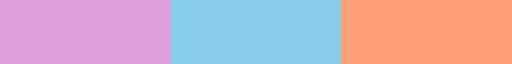

In [37]:
cmap_class

In [38]:
# Exclude doublet_geps
gep_order = []
for gep_type in [blood_only_geps, tiss_only_geps, other_geps,# doublet_geps
                ]:
    # gep_order += list(np.sum(gep_by_ds.loc[gep_type, :], axis = 1).sort_values(ascending = False).index)
    gep_count_class = pd.concat([np.sum(gep_by_ds.loc[gep_type, :], axis = 1).rename('num_geps'), 
                                 gep_classes.loc[gep_type, 0].rename('class')], axis = 1)
    gep_order += list(gep_count_class.sort_values(['num_geps' , 'class'], ascending = [False, True]).index)

In [39]:
from matplotlib import cm
tab20 = cm.get_cmap('tab20', 20)
# rocket_binarized = cm.get_cmap('rocket', 2)

In [40]:
# # Order GEPs by decreasing average usage
# mean_gep_by_ds = usage_norm.groupby(meta.loc[usage_norm.index, 'dataset']).mean().T

# # Exclude doublet_geps
# gep_order_usage = []
# for gep_type, datasets in zip([blood_only_geps, tiss_only_geps, other_geps], 
#                               [blood_datasets, tiss_datasets, blood_datasets + tiss_datasets]):
#     gep_order_usage += list(mean_gep_by_ds.loc[gep_type, datasets
#                                               ].mean(axis = 1).sort_values(ascending = False).index)

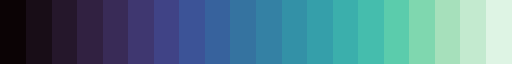

In [41]:
mako = cm.get_cmap('mako', 20)
mako

In [42]:
# cube_helix = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# cube_helix_bin = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#000648", "#B7D0FF"], N = 2)
# cube_helix_bin

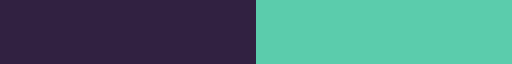

In [43]:
mako_bin = matplotlib.colors.LinearSegmentedColormap.from_list("", [mako(3), mako(15)], N = 2)
mako_bin

Blood
Tissue


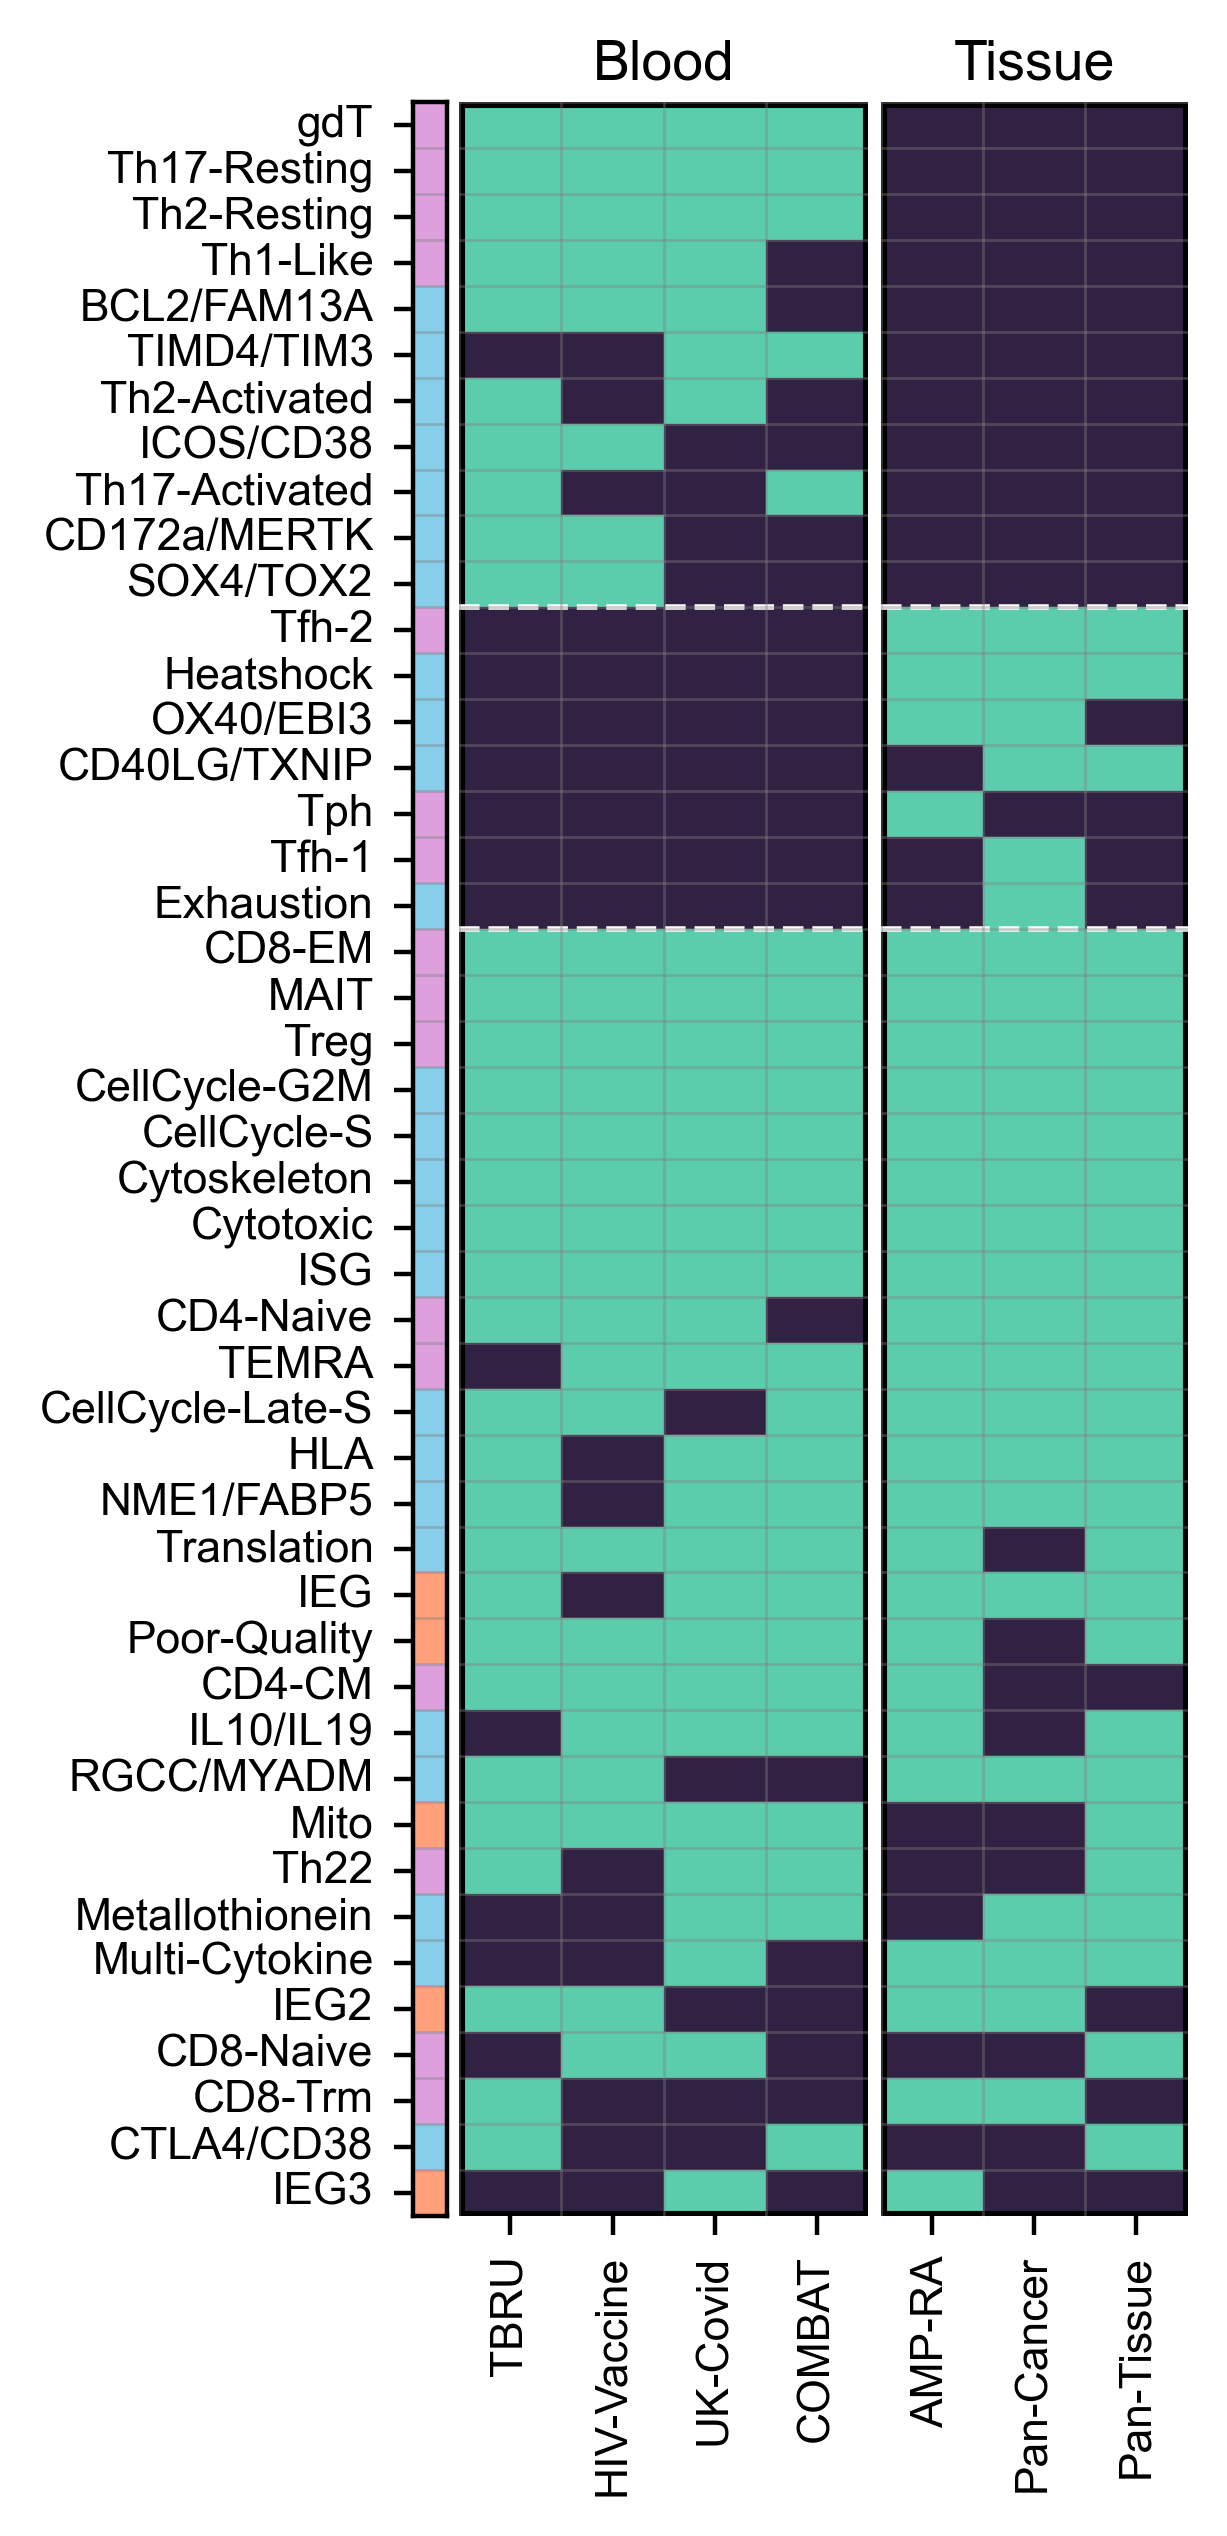

In [45]:
nrows = 1
ncols = len(tiss_order_small)+1
panel_height = .8
hspace = 0.05
figure_width = 2.5
figure_height = 7
# heatmap_width = 4
wspace = .05
cbar_fontsize=6
x_margin_scalar = 1
ytick_fontsize = tick_fontsize#8 
xtick_fontsize = tick_fontsize#8

row_norm = True
usgvmax =1 

fig = plt.figure(constrained_layout=False, dpi= 400, figsize=(figure_width,figure_height)) 
axes = []
gs = fig.add_gridspec(nrows, ncols, 
                      width_ratios = [1/3] + list(pd.Series([ds[1] for ds in ds_order]).value_counts()[tiss_order_small].values),
                      #width_ratios = usage_meta_test[pheno].value_counts()[pheno_order[i]],
                      wspace=.05, hspace=hspace)

for k in range(nrows):
    rowax = []
    for j in range(ncols):
        if k != (nrows-1):
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
        else:
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
    axes.append(rowax)
axes = np.array(axes)


# Color bar
# Plot ticks on left axis
i = 0
sns.heatmap(gep_classes.loc[gep_order, :], cmap = cmap_class, ax = axes[0, i], cbar = False)
axes[0, i].set_yticks(np.arange(0+.5, len(gep_order)+.5, 1))
axes[0, i].set_yticklabels(gep_order, fontsize=ytick_fontsize)
axes[0, i].set_xticks([])
for n in range(len(gep_order)):
    axes[0, i].hlines(xmin = 0, xmax = 10, y = n,
                      # linestyles = 'dashed', 
                      colors = 'grey', linewidth = .5, alpha = 0.4)
for spine in ['top', 'right', 'left', 'bottom']:
    axes[0, i].spines[spine].set_visible(True)

        
for i, tissue in enumerate(tiss_order_small):
    i = i+1
    prg_label = gep_order
    # if i==0:
    #     prg_label = row_order
    #     # prg_label = [prg.split('_')[-1] for prg in row_order] # True
    # else:
    #     prg_label = row_order#False

    print(tissue)
    ds_order_subset = [ds for ds in ds_order if ds[1]==tissue]
    sns.heatmap(gep_by_ds.loc[gep_order, [ds[0] for ds in ds_order_subset]], ### Or manually specify
            ax=axes[0, i], cbar=False, yticklabels=prg_label, 
            #xticklabels = pd.Series(col_order).replace(pheno_label[i]),
           #vmin = 0, vmax = usgvmax
               cmap = mako_bin #sns.light_palette("#7598ff", as_cmap=True )#sns.light_palette("#7598ff", as_cmap=True)
               )
    axes[0, i].set_xlabel(tissue, fontsize = label_fontsize)
    axes[0, i].xaxis.set_label_position('top')
    
    axes[0, i].set_xticklabels([ds[0] for ds in ds_order_subset], #axes[0, i].get_xticklabels(), 
                               rotation = 90, fontsize = xtick_fontsize)


    # Plot ticks on right axis
    if i in [1, 2]:
        axes[0, i].yaxis.tick_right()
        ticks = [] # which ticks to plot
        axes[0, i].set_yticks([])
        
        
    shape = gep_by_ds.loc[gep_order, [ds[0] for ds in ds_order_subset]].shape
    axes[0, i].add_patch(Rectangle((0, 0), shape[1], shape[0], fill=False, edgecolor='black', lw=2))
    
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps) + len(tiss_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)

    for n in range(len(gep_order)):
        axes[0, i].hlines(xmin = 0, xmax = 10, y = n,
                          # linestyles = 'dashed', 
                          colors = 'grey', linewidth = .5, alpha = 0.4)
    for n in range(len(ds_order_subset)):
        axes[0, i].vlines(ymin = 0, ymax = len(gep_order), x = n,
                          # linestyles = 'dashed', 
                          colors = 'grey', linewidth = .5, alpha = 0.4)

# handles_ds = []
# legend_dict = {'Present' : rocket_binarized(1), #sns.light_palette("#7598ff")[-1], 
#                'Not Present' : rocket_binarized(0)#sns.light_palette("#7598ff")[0]
#               }
# for key in legend_dict:
#         data_key = Patch(color=legend_dict[key], label=key)
#         handles_ds.append(data_key)
        
# handles_class = []
# class_legend_dict = dict(zip(class_order, class_colors))

# for key in class_legend_dict:
#         data_key = Patch(color=class_legend_dict[key], label=key)
#         handles_class.append(data_key)

# ph = [plt.plot([],marker="", ls="")[0]]*2
# handles = ph[:1]+ handles_class + ph[1:] + handles_ds 
# labels = ['GEP Class'] +list(class_legend_dict.keys()) + ['GEP in dataset'] + list(legend_dict.keys()) 
# leg = plt.legend(handles, labels, ncol=1, bbox_to_anchor=(-1.8, -.04, 0.2, 0.03), fontsize = 8)

# for vpack in leg._legend_handle_box.get_children():
#     for hpack in vpack.get_children()[:1] + vpack.get_children()[len(handles_class)+ 1:len(handles_class)+ 2]:
#         hpack.get_children()[0].set_width(0)

        
plt.savefig(os.path.join(figdir, 'GEPsDiscoveredByDataset_Heatmap.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'GEPsDiscoveredByDataset_Heatmap.pdf'), bbox_inches="tight")

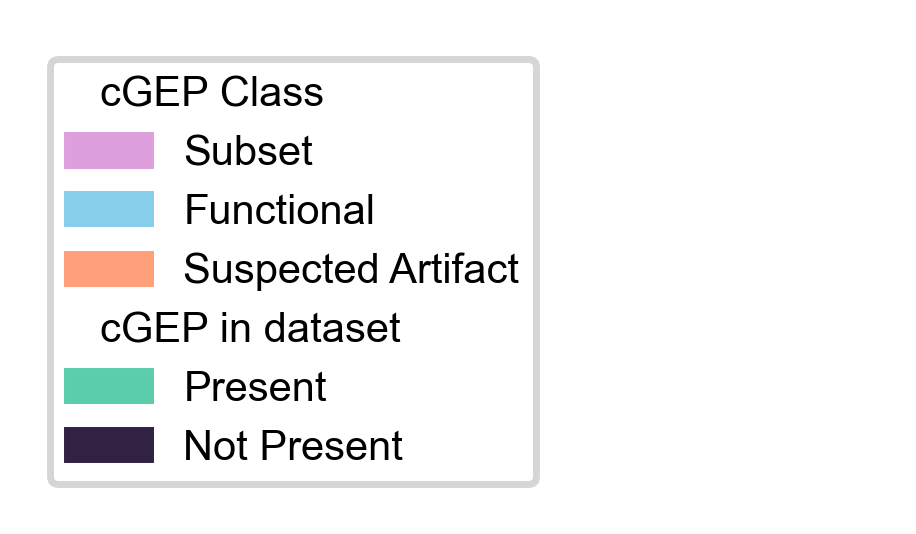

In [46]:
fig, ax = plt.subplots(dpi = 500, figsize = (1, 1))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

handles_ds = []
legend_dict = {'Present' : mako_bin(1), #sns.light_palette("#7598ff")[-1], 
               'Not Present' : mako_bin(0)#sns.light_palette("#7598ff")[0]
              }
for key in legend_dict:
        data_key = Patch(color=legend_dict[key], label=key)
        handles_ds.append(data_key)
        
handles_class = []
class_legend_dict = dict(zip(class_order, class_colors))

for key in class_legend_dict:
        data_key = Patch(color=class_legend_dict[key], label=key)
        handles_class.append(data_key)

ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[:1]+ handles_class + ph[1:] + handles_ds 
labels = ['cGEP Class'] +list(class_legend_dict.keys()) + ['cGEP in dataset'] + list(legend_dict.keys()) 
leg = plt.legend(handles, labels, ncol=1, bbox_to_anchor=(0, 1, 0.2, 0.03), fontsize = 6)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1] + vpack.get_children()[len(handles_class)+ 1:len(handles_class)+ 2]:
        hpack.get_children()[0].set_width(0)
        
plt.savefig(os.path.join(figdir, 'GEPsDiscoveredByDataset_Heatmap_Legend.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'GEPsDiscoveredByDataset_Heatmap_Legend.pdf'), bbox_inches="tight")
plt.show()

## Average usage per dataset 

In [47]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle



In [48]:
mean_gep_by_ds = usage_norm.groupby(meta.loc[usage_norm.index, 'dataset']).mean().T

In [49]:
# Exclude doublet_geps
gep_order_usage = []
for gep_type, datasets in zip([blood_only_geps, tiss_only_geps, other_geps], 
                              [blood_datasets, tiss_datasets, blood_datasets + tiss_datasets]):
    gep_order_usage += list(mean_gep_by_ds.loc[gep_type, datasets
                                              ].mean(axis = 1).sort_values(ascending = False).index)

<AxesSubplot:xlabel='dataset'>

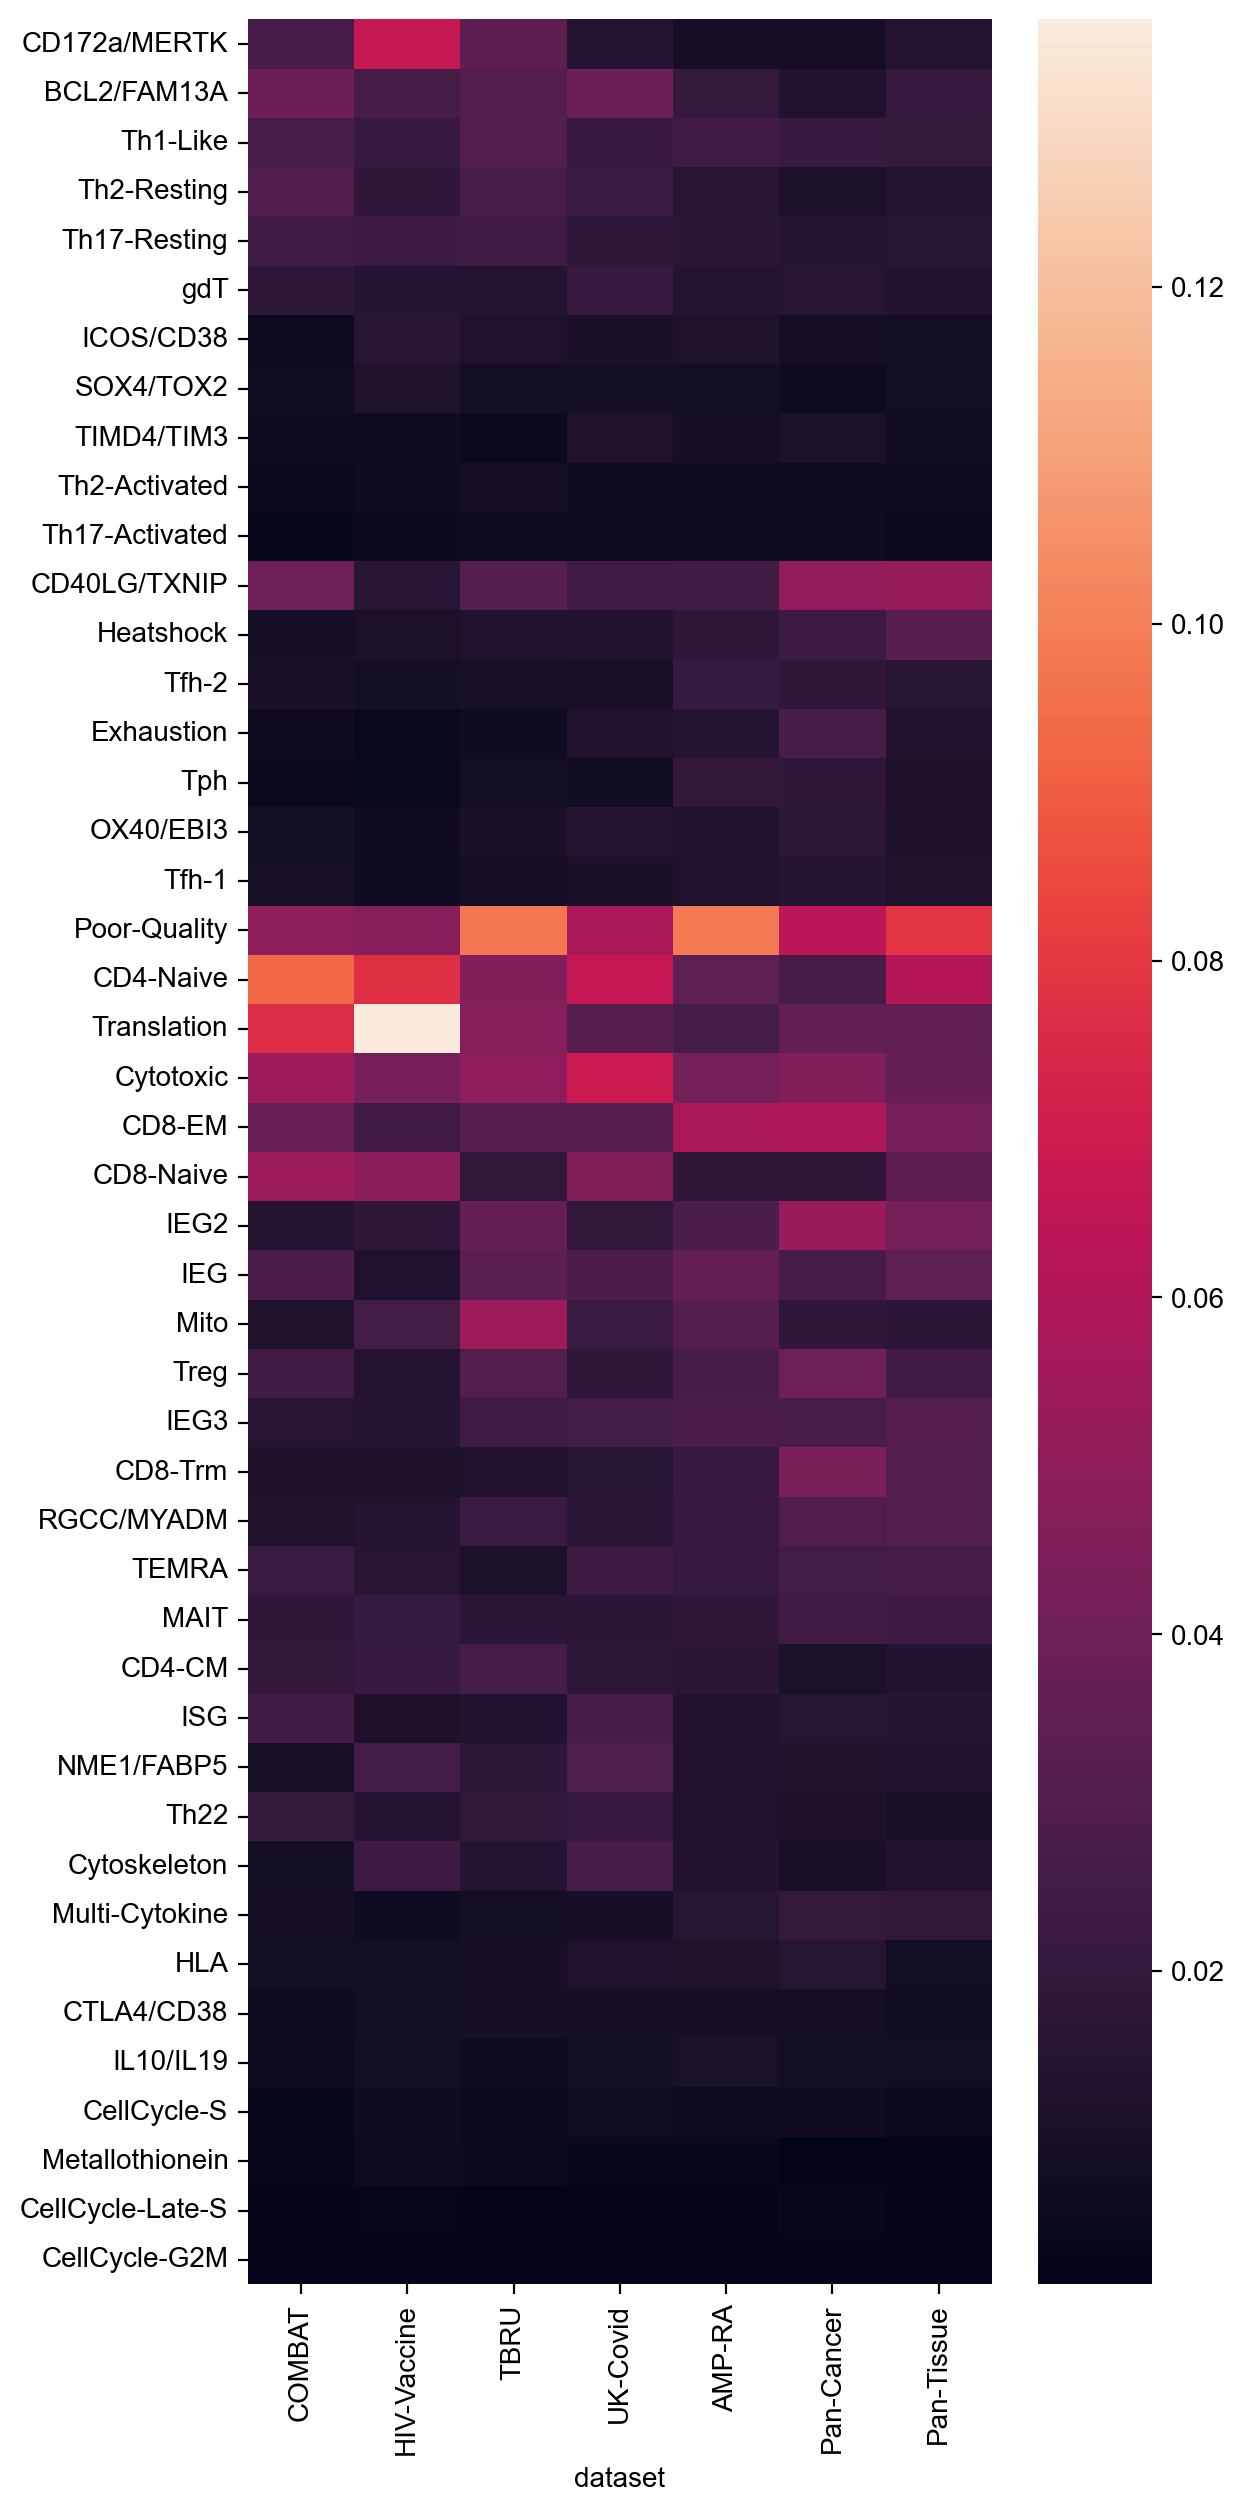

In [50]:
fig, ax = plt.subplots(figsize = (6, 15), dpi = 200)
sns.heatmap(mean_gep_by_ds.loc[gep_order_usage, blood_datasets + tiss_datasets], ax = ax)

Blood
Tissue


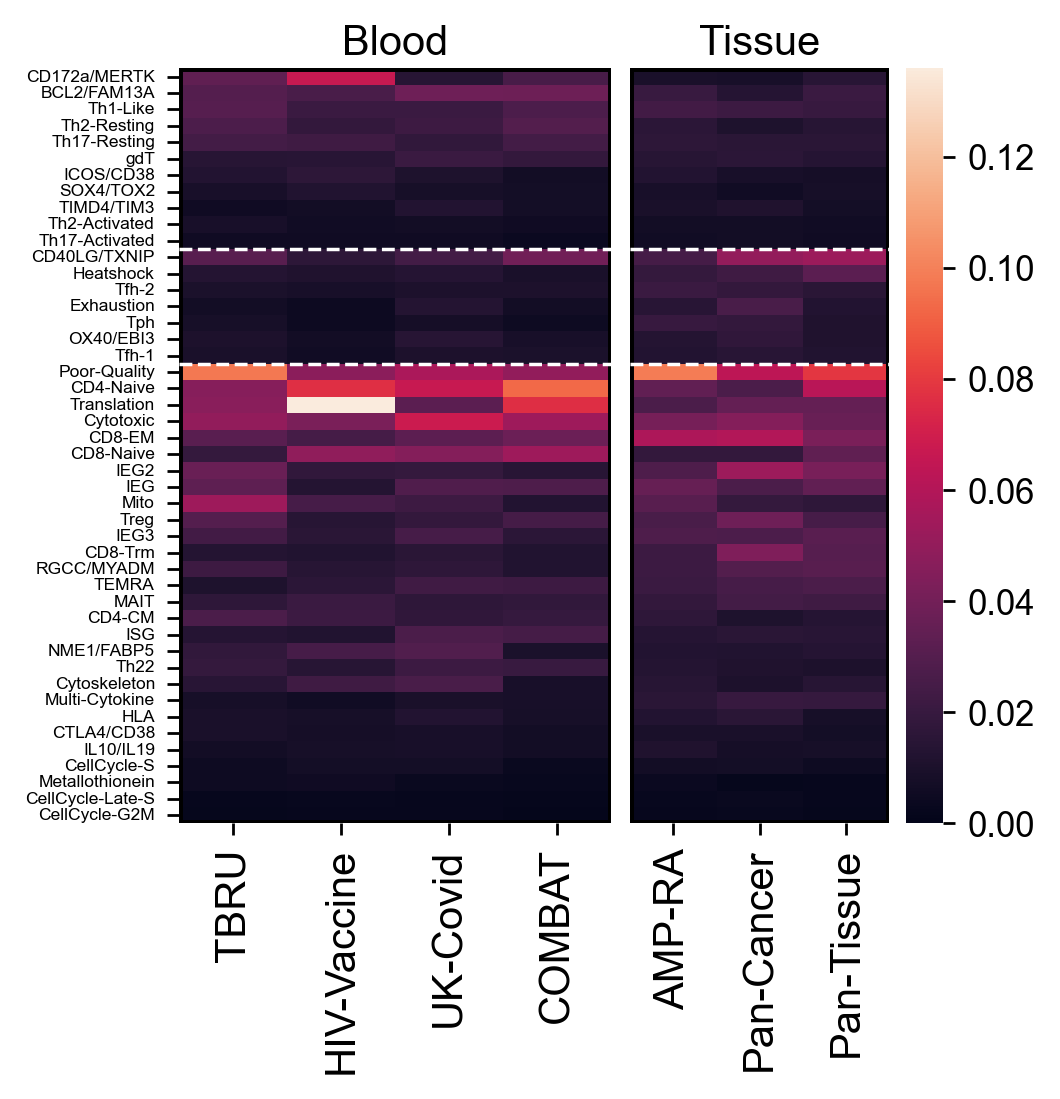

In [51]:
nrows = 1
ncols = len(tiss_order_small)
panel_height = .8
hspace = 0.05
figure_width = 4
figure_height = 4
# heatmap_width = 4
wspace = .05
cbar_fontsize=6
x_margin_scalar = 1
ytick_fontsize = 5
usgvmin = 0#mean_gep_by_ds.min().min()
usgvmax =mean_gep_by_ds.max().max()

fig = plt.figure(constrained_layout=False, dpi= 250, figsize=(figure_width,figure_height)) 
axes = []
gs = fig.add_gridspec(nrows, ncols, 
                      width_ratios = pd.Series([ds[1] for ds in ds_order]).value_counts()[tiss_order_small],
                      #width_ratios = usage_meta_test[pheno].value_counts()[pheno_order[i]],
                      wspace=.05, hspace=hspace)

for k in range(nrows):
    rowax = []
    for j in range(ncols):
        if k != (nrows-1):
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
        else:
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
    axes.append(rowax)
axes = np.array(axes)


for i, tissue in enumerate(tiss_order_small):
    prg_label = gep_order_usage
    # if i==0:
    #     prg_label = row_order
    #     # prg_label = [prg.split('_')[-1] for prg in row_order] # True
    # else:
    #     prg_label = row_order#False

    print(tissue)
    plot_cbar = (i==1)
    ds_order_subset = [ds for ds in ds_order if ds[1]==tissue]
    sns.heatmap(mean_gep_by_ds.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]], ### Or manually specify
            ax=axes[0, i], cbar=plot_cbar, yticklabels=prg_label,
            #xticklabels = pd.Series(col_order).replace(pheno_label[i]),
           vmin = usgvmin, vmax = usgvmax
               # cmap = sns.light_palette("#7598ff", as_cmap=True)
               )
    axes[0, i].set_xlabel(tissue, fontsize = 12)
    axes[0, i].xaxis.set_label_position('top')
    
    axes[0, i].set_xticklabels([ds[0] for ds in ds_order_subset], #axes[0, i].get_xticklabels(), 
                               rotation = 90, fontsize = 12)

    # Plot ticks on left axis
    if i==0:
        ticks = [] # which ticks to plot
        for index, label in enumerate(axes[0, i].yaxis.get_ticklabels()):
            if label.get_text() in gep_order_usage: #labels_left:
                ticks.append(axes[0, i].get_yticks()[index])
        axes[0, i].set_yticks(ticks, 
                              labels = pd.Index(gep_order_usage), 
                              fontsize = ytick_fontsize)

    # Plot ticks on right axis
    if i==1:
        axes[0, i].yaxis.tick_right()
        ticks = [] # which ticks to plot
        # for index, label in enumerate(axes[0, i].yaxis.get_ticklabels()):
        #     if label.get_text() in labels_right:
        #         ticks.append(axes[0, i].get_yticks()[index])
        # axes[0, i].set_yticks(ticks, 
        #                       labels = pd.Index(labels_right).map(display_prg), 
        #                       fontsize = ytick_fontsize, rotation = 0)
        axes[0, i].set_yticks([])
        
        
    shape = mean_gep_by_ds.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]].shape
    axes[0, i].add_patch(Rectangle((0, 0), shape[1], shape[0], fill=False, edgecolor='black', lw=2))
    
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps) + len(tiss_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)

    # for n in range(len(row_order)):
    #     axes[0, i].hlines(xmin = 0, xmax = 10, y = n,
    #                       # linestyles = 'dashed', 
    #                       colors = 'grey', linewidth = .5, alpha = 0.4)
    # for n in range(len(ds_order_subset)):
    #     axes[0, i].vlines(ymin = 0, ymax = len(row_order), x = n,
    #                       # linestyles = 'dashed', 
    #                       colors = 'grey', linewidth = .5, alpha = 0.4)

# fig.suptitle('GEP discovery by dataset/tissue', fontsize = 15)



# handles = []
# legend_dict = {'Present' : sns.light_palette("#7598ff")[-1], 
#                'Not Present' : sns.light_palette("#7598ff")[0]}
# for key in legend_dict:
#         data_key = Patch(color=legend_dict[key], label=key)
#         handles.append(data_key)
# plt.legend(handles=handles, bbox_to_anchor=(-1.5, -.1, 0.2, 0.03), fontsize = 8)


Blood
Tissue


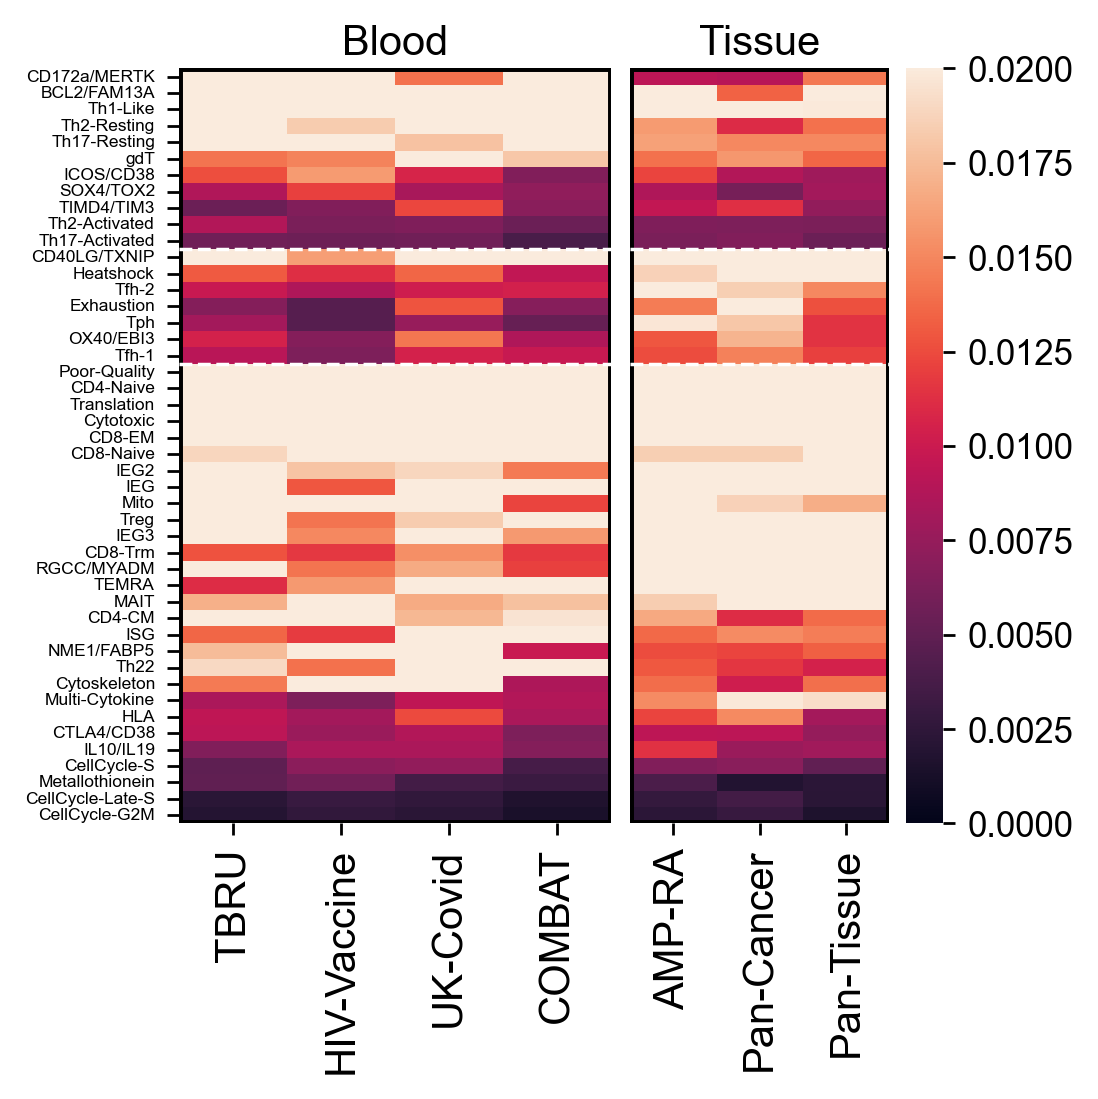

In [52]:
nrows = 1
ncols = len(tiss_order_small)
panel_height = .8
hspace = 0.05
figure_width = 4
figure_height = 4
# heatmap_width = 4
wspace = .05
cbar_fontsize=6
x_margin_scalar = 1
ytick_fontsize = 5
usgvmin = 0#mean_gep_by_ds.min().min()
usgvmax = 0.02 #mean_gep_by_ds.max().max()

fig = plt.figure(constrained_layout=False, dpi= 250, figsize=(figure_width,figure_height)) 
axes = []
gs = fig.add_gridspec(nrows, ncols, 
                      width_ratios = pd.Series([ds[1] for ds in ds_order]).value_counts()[tiss_order_small],
                      #width_ratios = usage_meta_test[pheno].value_counts()[pheno_order[i]],
                      wspace=.05, hspace=hspace)

for k in range(nrows):
    rowax = []
    for j in range(ncols):
        if k != (nrows-1):
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
        else:
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
    axes.append(rowax)
axes = np.array(axes)


for i, tissue in enumerate(tiss_order_small):
    prg_label = gep_order_usage
    # if i==0:
    #     prg_label = row_order
    #     # prg_label = [prg.split('_')[-1] for prg in row_order] # True
    # else:
    #     prg_label = row_order#False

    print(tissue)
    plot_cbar = (i==1)
    ds_order_subset = [ds for ds in ds_order if ds[1]==tissue]
    sns.heatmap(mean_gep_by_ds.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]], ### Or manually specify
            ax=axes[0, i], cbar=plot_cbar, yticklabels=prg_label,
            #xticklabels = pd.Series(col_order).replace(pheno_label[i]),
           vmin = usgvmin, vmax = usgvmax
               # cmap = sns.light_palette("#7598ff", as_cmap=True)
               )
    axes[0, i].set_xlabel(tissue, fontsize = 12)
    axes[0, i].xaxis.set_label_position('top')
    
    axes[0, i].set_xticklabels([ds[0] for ds in ds_order_subset], #axes[0, i].get_xticklabels(), 
                               rotation = 90, fontsize = 12)

    # Plot ticks on left axis
    if i==0:
        ticks = [] # which ticks to plot
        for index, label in enumerate(axes[0, i].yaxis.get_ticklabels()):
            if label.get_text() in gep_order_usage: #labels_left:
                ticks.append(axes[0, i].get_yticks()[index])
        axes[0, i].set_yticks(ticks, 
                              labels = pd.Index(gep_order_usage), 
                              fontsize = ytick_fontsize)

    # Plot ticks on right axis
    if i==1:
        axes[0, i].yaxis.tick_right()
        ticks = [] # which ticks to plot
        # for index, label in enumerate(axes[0, i].yaxis.get_ticklabels()):
        #     if label.get_text() in labels_right:
        #         ticks.append(axes[0, i].get_yticks()[index])
        # axes[0, i].set_yticks(ticks, 
        #                       labels = pd.Index(labels_right).map(display_prg), 
        #                       fontsize = ytick_fontsize, rotation = 0)
        axes[0, i].set_yticks([])
        
        
    shape = mean_gep_by_ds.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]].shape
    axes[0, i].add_patch(Rectangle((0, 0), shape[1], shape[0], fill=False, edgecolor='black', lw=2))
    
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps) + len(tiss_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)

    # for n in range(len(row_order)):
    #     axes[0, i].hlines(xmin = 0, xmax = 10, y = n,
    #                       # linestyles = 'dashed', 
    #                       colors = 'grey', linewidth = .5, alpha = 0.4)
    # for n in range(len(ds_order_subset)):
    #     axes[0, i].vlines(ymin = 0, ymax = len(row_order), x = n,
    #                       # linestyles = 'dashed', 
    #                       colors = 'grey', linewidth = .5, alpha = 0.4)

# fig.suptitle('GEP discovery by dataset/tissue', fontsize = 15)



# handles = []
# legend_dict = {'Present' : sns.light_palette("#7598ff")[-1], 
#                'Not Present' : sns.light_palette("#7598ff")[0]}
# for key in legend_dict:
#         data_key = Patch(color=legend_dict[key], label=key)
#         handles.append(data_key)
# plt.legend(handles=handles, bbox_to_anchor=(-1.5, -.1, 0.2, 0.03), fontsize = 8)


In [53]:
from sklearn.preprocessing import MinMaxScaler


In [54]:
scaler = MinMaxScaler()
col_normed = scaler.fit_transform(mean_gep_by_ds)
col_normed = pd.DataFrame(col_normed, index = mean_gep_by_ds.index,
                         columns = mean_gep_by_ds.columns)

<AxesSubplot:xlabel='dataset'>

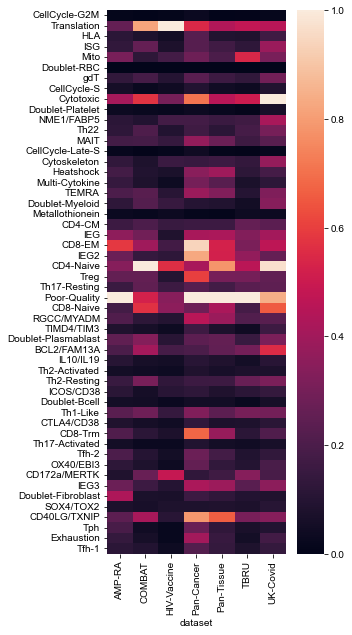

In [55]:
fig, ax = plt.subplots(figsize = (4, 10))
sns.heatmap(col_normed, )

Blood
Tissue


Text(0.5, 0.93, 'Column-normalized')

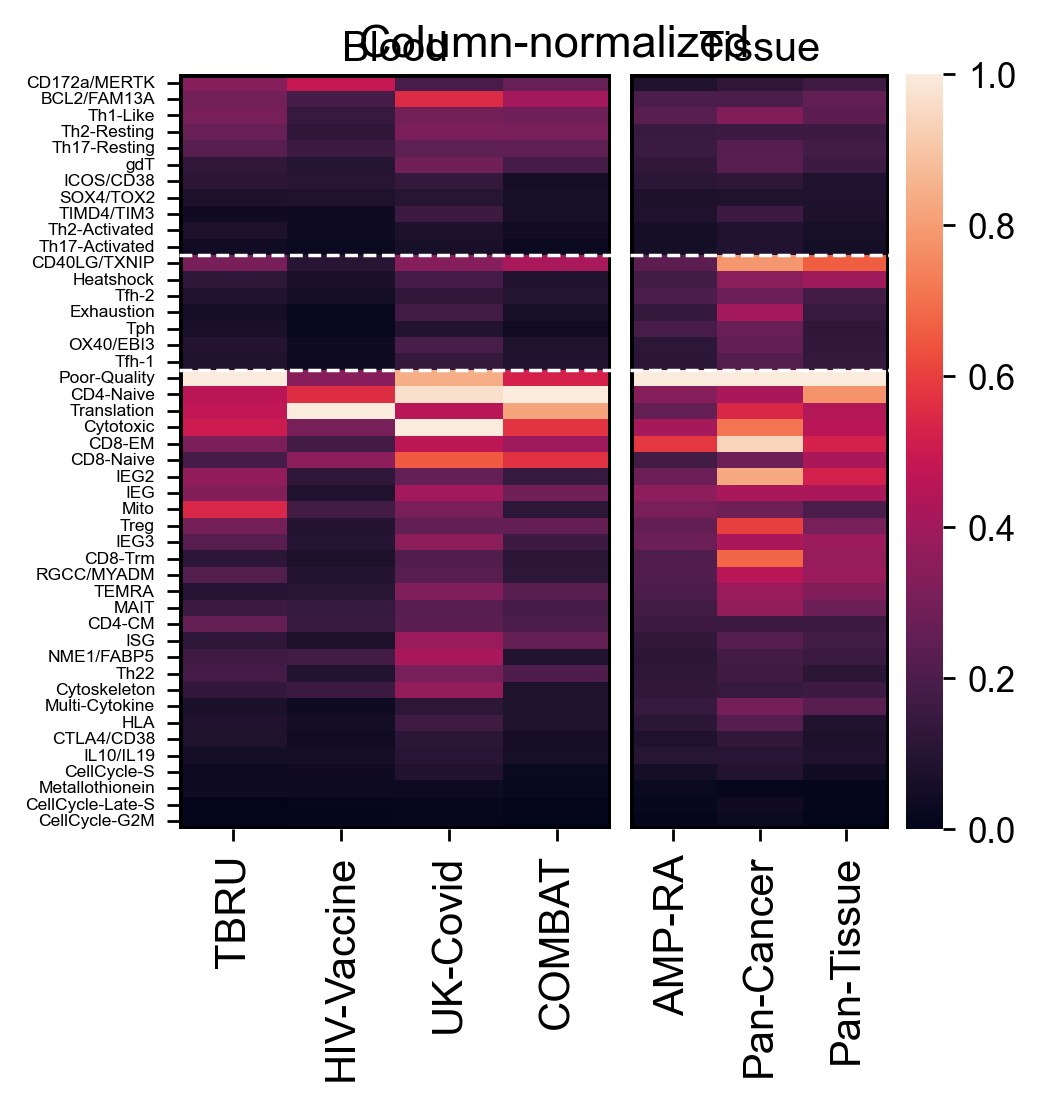

In [56]:
nrows = 1
ncols = len(tiss_order_small)
panel_height = .8
hspace = 0.05
figure_width = 4
figure_height = 4
# heatmap_width = 4
wspace = .05
cbar_fontsize=6
x_margin_scalar = 1
ytick_fontsize = 5

usgvmin = col_normed.min().min()#mean_gep_by_ds.min().min()
usgvmax =col_normed.max().max()

fig = plt.figure(constrained_layout=False, dpi= 250, figsize=(figure_width,figure_height)) 
axes = []
gs = fig.add_gridspec(nrows, ncols, 
                      width_ratios = pd.Series([ds[1] for ds in ds_order]).value_counts()[tiss_order_small],
                      #width_ratios = usage_meta_test[pheno].value_counts()[pheno_order[i]],
                      wspace=.05, hspace=hspace)

for k in range(nrows):
    rowax = []
    for j in range(ncols):
        if k != (nrows-1):
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
        else:
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
    axes.append(rowax)
axes = np.array(axes)


for i, tissue in enumerate(tiss_order_small):
    prg_label = gep_order_usage
    # if i==0:
    #     prg_label = row_order
    #     # prg_label = [prg.split('_')[-1] for prg in row_order] # True
    # else:
    #     prg_label = row_order#False

    print(tissue)
    plot_cbar = (i==1)
    ds_order_subset = [ds for ds in ds_order if ds[1]==tissue]
    sns.heatmap(col_normed.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]], ### Or manually specify
            ax=axes[0, i], cbar=plot_cbar, yticklabels=prg_label,
            #xticklabels = pd.Series(col_order).replace(pheno_label[i]),
           vmin = usgvmin, vmax = usgvmax
               # cmap = sns.light_palette("#7598ff", as_cmap=True)
               )
    axes[0, i].set_xlabel(tissue, fontsize = 12)
    axes[0, i].xaxis.set_label_position('top')
    
    axes[0, i].set_xticklabels([ds[0] for ds in ds_order_subset], #axes[0, i].get_xticklabels(), 
                               rotation = 90, fontsize = 12)

    # Plot ticks on left axis
    if i==0:
        ticks = [] # which ticks to plot
        for index, label in enumerate(axes[0, i].yaxis.get_ticklabels()):
            if label.get_text() in gep_order_usage: #labels_left:
                ticks.append(axes[0, i].get_yticks()[index])
        axes[0, i].set_yticks(ticks, 
                              labels = pd.Index(gep_order_usage), 
                              fontsize = ytick_fontsize)

    # Plot ticks on right axis
    if i==1:
        axes[0, i].yaxis.tick_right()
        ticks = [] # which ticks to plot
        # for index, label in enumerate(axes[0, i].yaxis.get_ticklabels()):
        #     if label.get_text() in labels_right:
        #         ticks.append(axes[0, i].get_yticks()[index])
        # axes[0, i].set_yticks(ticks, 
        #                       labels = pd.Index(labels_right).map(display_prg), 
        #                       fontsize = ytick_fontsize, rotation = 0)
        axes[0, i].set_yticks([])
        
        
    shape = col_normed.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]].shape
    axes[0, i].add_patch(Rectangle((0, 0), shape[1], shape[0], fill=False, edgecolor='black', lw=2))
    
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps) + len(tiss_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)

fig.suptitle('Column-normalized', y = .93, fontsize = 13)
    # for n in range(len(row_order)):
    #     axes[0, i].hlines(xmin = 0, xmax = 10, y = n,
    #                       # linestyles = 'dashed', 
    #                       colors = 'grey', linewidth = .5, alpha = 0.4)
    # for n in range(len(ds_order_subset)):
    #     axes[0, i].vlines(ymin = 0, ymax = len(row_order), x = n,
    #                       # linestyles = 'dashed', 
    #                       colors = 'grey', linewidth = .5, alpha = 0.4)

# fig.suptitle('GEP discovery by dataset/tissue', fontsize = 15)



# handles = []
# legend_dict = {'Present' : sns.light_palette("#7598ff")[-1], 
#                'Not Present' : sns.light_palette("#7598ff")[0]}
# for key in legend_dict:
#         data_key = Patch(color=legend_dict[key], label=key)
#         handles.append(data_key)
# plt.legend(handles=handles, bbox_to_anchor=(-1.5, -.1, 0.2, 0.03), fontsize = 8)


In [57]:
scaler = MinMaxScaler()
row_normed = scaler.fit_transform(mean_gep_by_ds.T)


In [58]:
row_normed = pd.DataFrame(row_normed.T, index = mean_gep_by_ds.index,
                         columns = mean_gep_by_ds.columns)

<AxesSubplot:xlabel='dataset'>

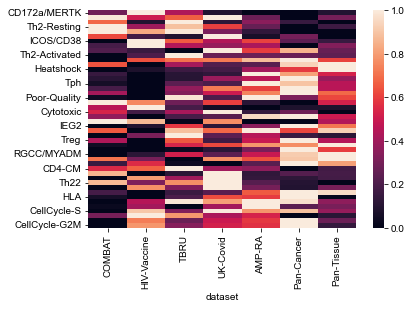

In [59]:
sns.heatmap(row_normed.loc[gep_order_usage, blood_datasets + tiss_datasets])

Blood
Tissue


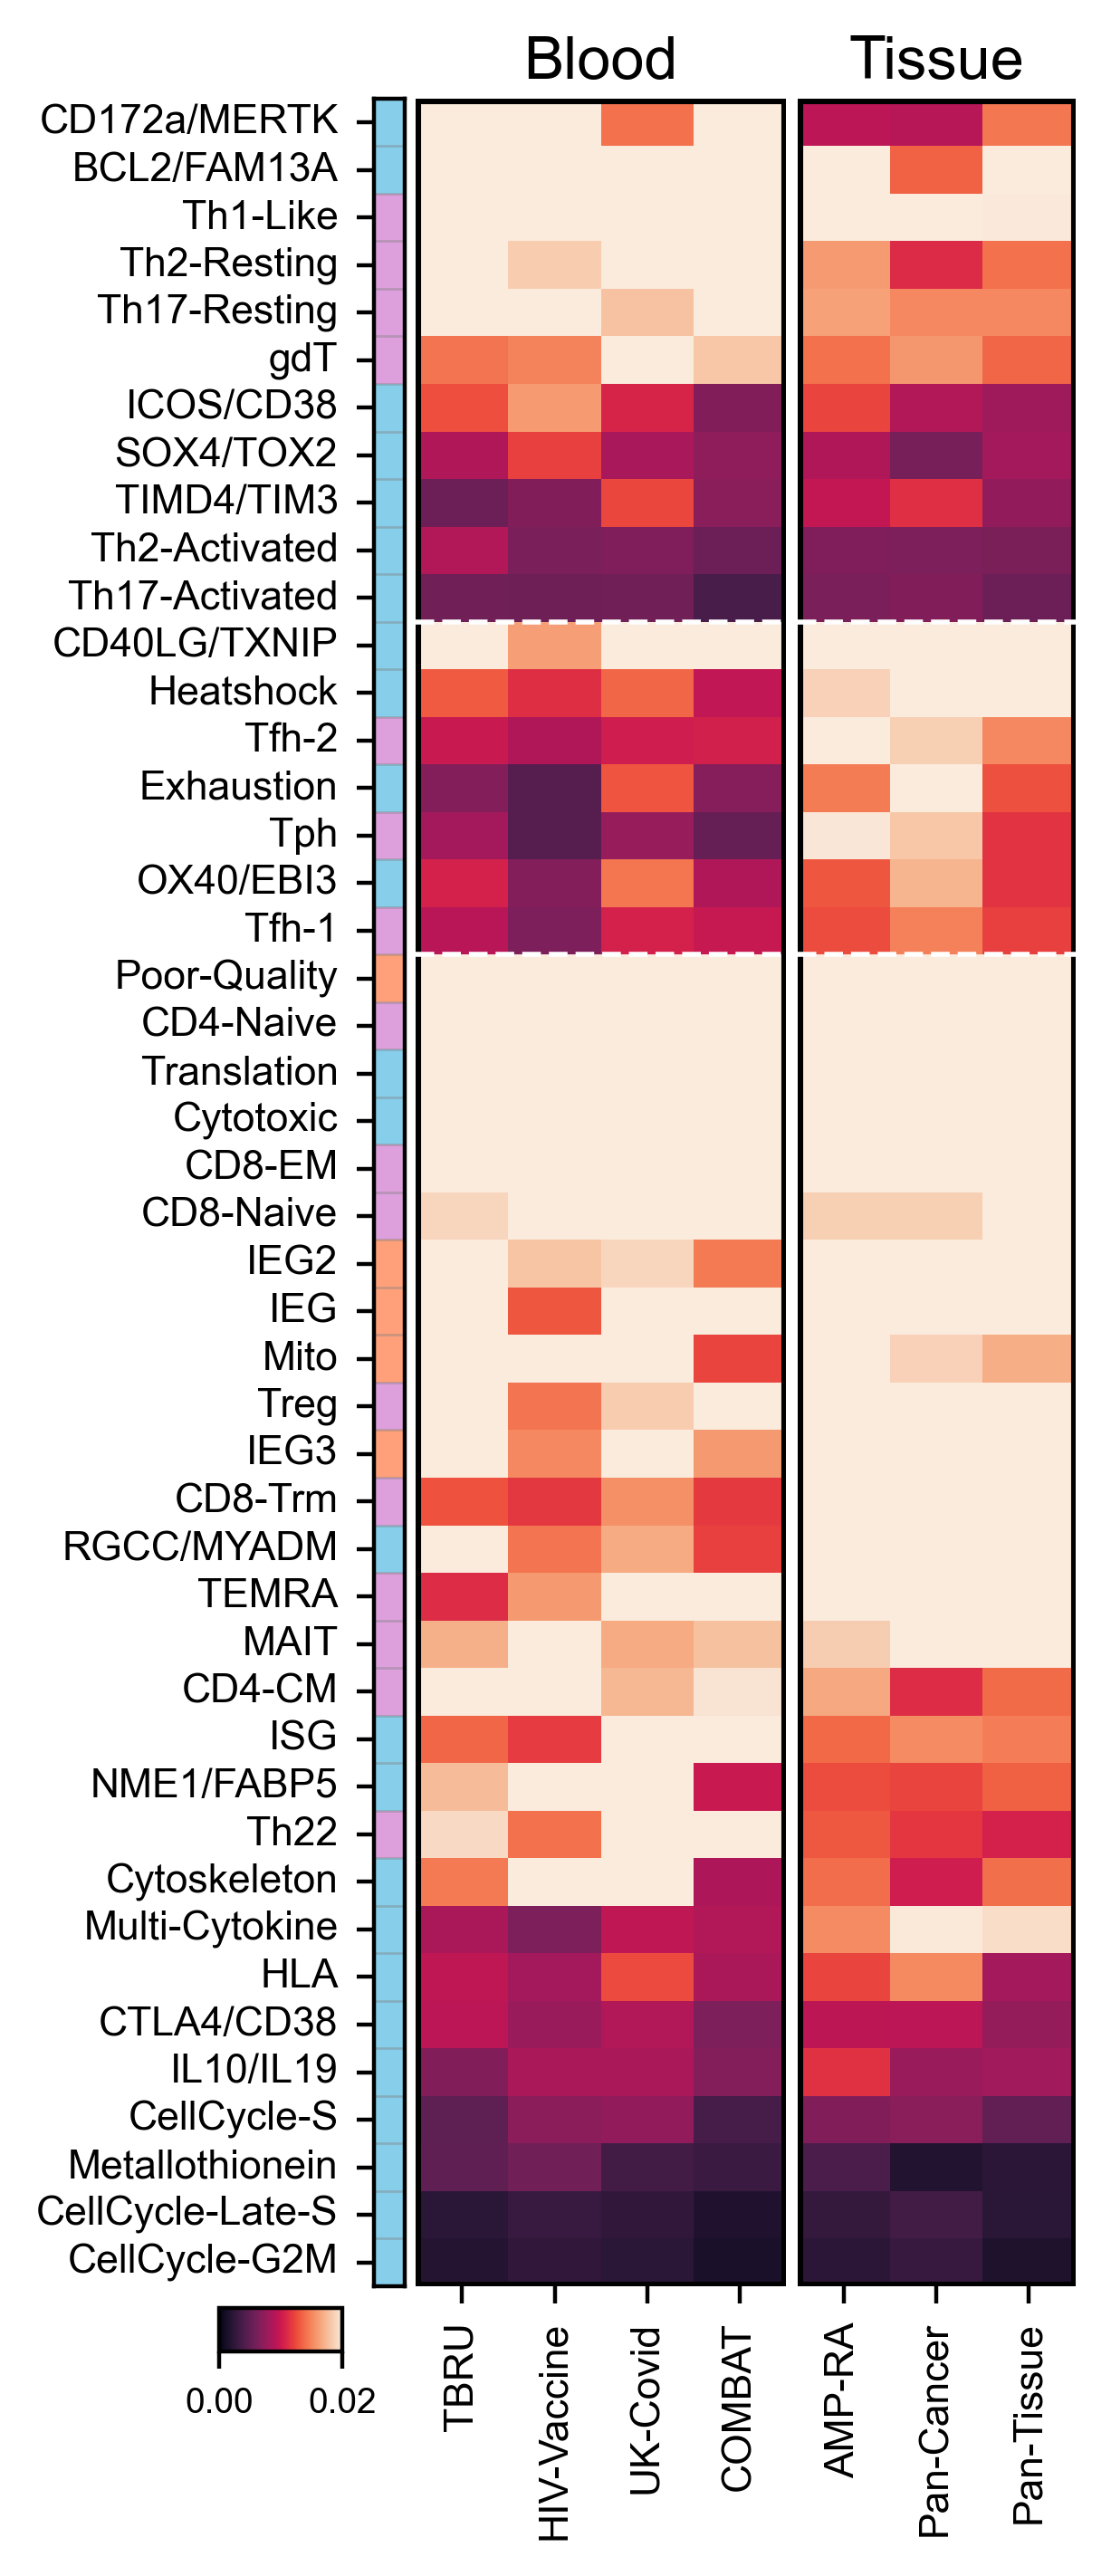

In [66]:
nrows = 1
ncols = len(tiss_order_small)+1
panel_height = .8
hspace = 0.05
figure_width = 2.5
figure_height = 8
# heatmap_width = 4
wspace = .05
cbar_fontsize=6
x_margin_scalar = 1
ytick_fontsize = 8
xtick_fontsize = 8
usgvmin = 0
usgvmax =0.02

fig = plt.figure(constrained_layout=False, dpi= 400, figsize=(figure_width,figure_height)) 
axes = []
gs = fig.add_gridspec(nrows, ncols, 
                      width_ratios = [1/3] + list(pd.Series([ds[1] for ds in ds_order]).value_counts()[tiss_order_small].values),
                      #width_ratios = usage_meta_test[pheno].value_counts()[pheno_order[i]],
                      wspace=.05, hspace=hspace)

for k in range(nrows):
    rowax = []
    for j in range(ncols):
        if k != (nrows-1):
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
        else:
            rowax.append(fig.add_subplot(gs[k, j], xticks=[], yticks=[]))
    axes.append(rowax)
axes = np.array(axes)

# Color bar
# Plot ticks on left axis
i = 0
sns.heatmap(gep_classes.loc[gep_order_usage, :], cmap = cmap_class, ax = axes[0, i], cbar = False)
axes[0, i].set_yticks(np.arange(0+.5, len(gep_order_usage)+.5, 1))
axes[0, i].set_yticklabels(gep_order_usage, fontsize=ytick_fontsize)
axes[0, i].set_xticks([])
for n in range(len(gep_order_usage)):
    axes[0, i].hlines(xmin = 0, xmax = 10, y = n,
                      # linestyles = 'dashed', 
                      colors = 'grey', linewidth = .5, alpha = 0.4)
for spine in ['top', 'right', 'left', 'bottom']:
    axes[0, i].spines[spine].set_visible(True)

    
for i, tissue in enumerate(tiss_order_small):
    i = i+1
    prg_label = gep_order_usage
    # if i==0:
    #     prg_label = row_order
    #     # prg_label = [prg.split('_')[-1] for prg in gep_order] # True
    # else:
    #     prg_label = row_order#False

    print(tissue)
    plot_cbar = False#(i==2)
    ds_order_subset = [ds for ds in ds_order if ds[1]==tissue]
    sns.heatmap(mean_gep_by_ds.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]], ### Or manually specify
            ax=axes[0, i], cbar=plot_cbar, yticklabels=prg_label,
            #xticklabels = pd.Series(col_order).replace(pheno_label[i]),
           vmin = usgvmin, vmax = usgvmax
               # cmap = sns.light_palette("#7598ff", as_cmap=True)
               )
    axes[0, i].set_xlabel(tissue, fontsize = 12)
    axes[0, i].xaxis.set_label_position('top')
    
    axes[0, i].set_xticklabels([ds[0] for ds in ds_order_subset], #axes[0, i].get_xticklabels(), 
                               rotation = 90, fontsize = xtick_fontsize)


    # Plot ticks on right axis
    if i in [1,2 ]:
        axes[0, i].yaxis.tick_right()
        ticks = [] # which ticks to plot
        axes[0, i].set_yticks([])
        
        
    shape = mean_gep_by_ds.loc[gep_order_usage, [ds[0] for ds in ds_order_subset]].shape
    axes[0, i].add_patch(Rectangle((0, 0), shape[1], shape[0], fill=False, edgecolor='black', lw=2))
    
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)
    axes[0, i].hlines(xmin = 0, xmax = 10, y = len(blood_only_geps) + len(tiss_only_geps),
                      linestyles = 'dashed', colors = 'white', linewidth = 1)

    

cax = axes[0, 0].inset_axes([-5, -.03, 4, 0.02], transform=axes[0, 0].transAxes)
fig.colorbar(ScalarMappable(norm=Normalize(vmin=usgvmin, vmax=usgvmax), 
                        cmap=sns.color_palette("rocket", as_cmap=True)),
         ax=axes[0, 0], cax=cax, orientation='horizontal')
cax.set_xticks([usgvmin, usgvmax])
cax.set_xticklabels(['%.2f' % usgvmin , #'%.2f' % vmin, 
                 '%.2f' % usgvmax])
cax.tick_params(labelsize=7)

# fig.suptitle('Row-normalized', y = .93, fontsize = 13)
plt.savefig(os.path.join(figdir, 'MeanUsageByDataset_Heatmap.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'MeanUsageByDataset_Heatmap.pdf'), bbox_inches="tight")
plt.show()

# Correlations

## Heatmap

### All GEPs

In [67]:
### Include only programs that are part of finalized set
R_filt = R.loc[clus_df.unstack().dropna().values.tolist(),
              clus_df.unstack().dropna().values.tolist()]

In [68]:
R.shape, R_filt.shape

((267, 267), (218, 218))

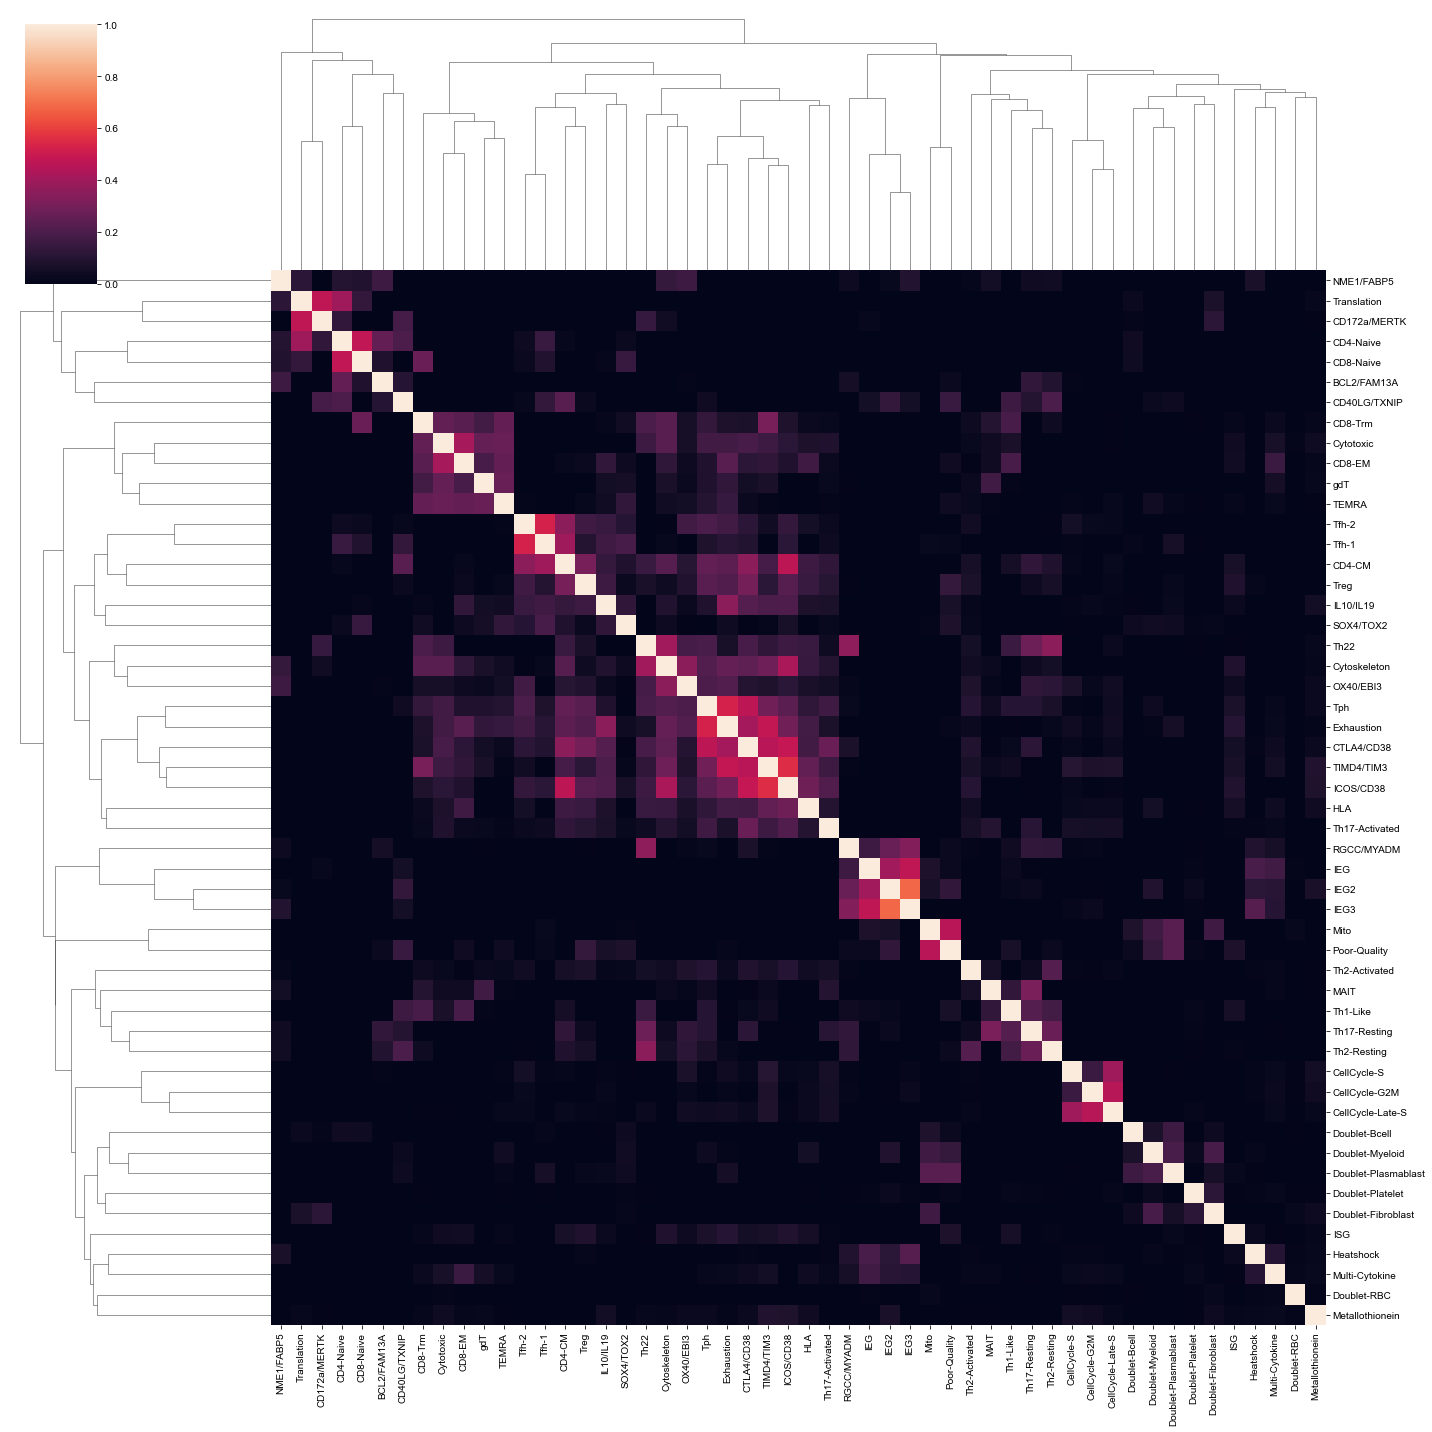

In [69]:
# Order prgs by most correlated meta-clusters
# Correlations of second round of program merging
R_meta = gene_scores_grouped.T.corr()

g = sns.clustermap(R_meta, vmin = 0, vmax = 1, figsize = (20, 20))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 10)
plt.show()

meta_row_order = R_meta.index[g.dendrogram_row.reordered_ind]

In [70]:
gep_corr_order = clus_df.loc[meta_row_order,:].T.unstack().dropna().values.tolist()

In [71]:
len(gep_corr_order)

218

In [72]:
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize


In [73]:
fig, ax = plt.subplots(dpi = 250, figsize = (60, 60))
sns.heatmap(R_filt.loc[gep_corr_order , gep_corr_order], vmin = 0, vmax = 1, cbar=False, cmap = 'plasma')
ax.set_xlabel('GEP')
ax.set_ylabel('GEP')
ax.set_title('Pairwise GEP correlations')
ax.tick_params(left=False, bottom=False)
cax = ax.inset_axes([-.15, .95, 0.1, 0.05], transform=ax.transAxes)
fig.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), 
                            cmap=sns.color_palette("plasma", as_cmap=True)),
             ax=ax, cax=cax, orientation='horizontal')

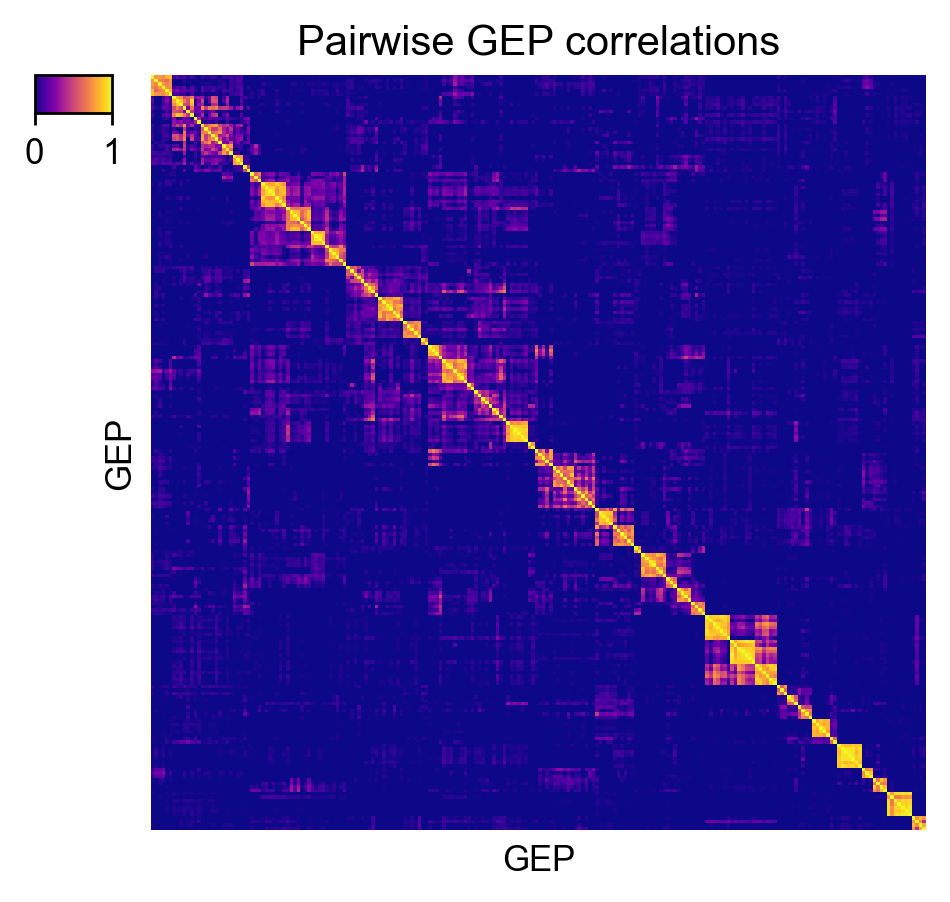

In [74]:
fig, ax = plt.subplots(dpi = 250, figsize = (4, 4))
sns.heatmap(R_filt.loc[gep_corr_order , gep_corr_order], vmin = 0, vmax = 1, cbar=False,
           yticklabels=False, xticklabels=False, cmap = 'plasma')
ax.set_xlabel('GEP')
ax.set_ylabel('GEP')
ax.set_title('Pairwise GEP correlations')
ax.tick_params(left=False, bottom=False)
cax = ax.inset_axes([-.15, .95, 0.1, 0.05], transform=ax.transAxes)
fig.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), 
                            cmap=sns.color_palette("plasma", as_cmap=True)),
             ax=ax, cax=cax, orientation='horizontal')

Highlight regions of interest.

In [75]:
from matplotlib.patches import Rectangle


In [76]:
clus_df.dropna()

AMP-RA                TBRU  \
CellCycle-G2M  AMP-RA:CellCycle-G2M  TBRU:CellCycle-G2M   
ISG                      AMP-RA:ISG            TBRU:ISG   
Doublet-RBC      AMP-RA:Doublet-RBC    TBRU:Doublet-RBC   
CellCycle-S      AMP-RA:CellCycle-S    TBRU:CellCycle-S   
Cytotoxic          AMP-RA:Cytotoxic      TBRU:Cytotoxic   
MAIT                    AMP-RA:MAIT           TBRU:MAIT   
Cytoskeleton    AMP-RA:Cytoskeleton   TBRU:Cytoskeleton   
CD8-EM                AMP-RA:CD8_EM         TBRU:CD8_EM   
Treg                    AMP-RA:Treg           TBRU:Treg   

                             UK-Covid                                COMBAT  \
CellCycle-G2M  UK-Covid:CellCycle-G2M                  COMBAT:CellCycle-G2M   
ISG                      UK-Covid:ISG                            COMBAT:ISG   
Doublet-RBC      UK-Covid:Doublet-RBC                    COMBAT:Doublet-RBC   
CellCycle-S      UK-Covid:CellCycle-S                    COMBAT:CellCycle-S   
Cytotoxic          UK-Covid:Cytotoxic                      COMBAT:Cytotoxic   
MAIT                    UK-Covid:MAIT                           COMBAT:MAIT   
Cytoskeleton    UK-Covid:Cytoskeleton  COMBAT:COMBAT:CellCycle_G2M_2_Single   
CD8-EM                UK-Covid:CD8_EM                         COMBAT:CD8_EM   
Treg                    UK-Covid:Treg                           COMBAT:Treg   

                             Pan-Cancer                Pan-Tissue  \
CellCycle-G2M  Pan-Cancer:CellCycle-G2M  Pan-Tissue:CellCycle-G2M   
ISG                      Pan-Cancer:ISG            Pan-Tissue:ISG   
Doublet-RBC      Pan-Cancer:Doublet-RBC    Pan-Tissue:Doublet-RBC   
CellCycle-S      Pan-Cancer:CellCycle-S    Pan-Tissue:CellCycle-S   
Cytotoxic          Pan-Cancer:Cytotoxic      Pan-Tissue:Cytotoxic   
MAIT                    Pan-Cancer:MAIT           Pan-Tissue:MAIT   
Cytoskeleton    Pan-Cancer:Cytoskeleton   Pan-Tissue:Cytoskeleton   
CD8-EM                Pan-Cancer:CD8_EM         Pan-Tissue:CD8_EM   
Treg                    Pan-Cancer:Treg           Pan-Tissue:Treg   

                             HIV-Vaccine  
CellCycle-G2M  HIV-Vaccine:CellCycle-G2M  
ISG                      HIV-Vaccine:ISG  
Doublet-RBC      HIV-Vaccine:Doublet-RBC  
CellCycle-S      HIV-Vaccine:CellCycle-S  
Cytotoxic          HIV-Vaccine:Cytotoxic  
MAIT                    HIV-Vaccine:MAIT  
Cytoskeleton    HIV-Vaccine:Cytoskeleton  
CD8-EM                HIV-Vaccine:CD8_EM  
Treg                    HIV-Vaccine:Treg

In [77]:
cgeps_to_plot = list(clus_df.dropna().index[~clus_df.dropna().index.str.contains('Doublet')])
cgeps_to_plot

['CellCycle-G2M',
 'ISG',
 'CellCycle-S',
 'Cytotoxic',
 'MAIT',
 'Cytoskeleton',
 'CD8-EM',
 'Treg']

In [78]:
for cgep in cgeps_to_plot:
    print(cgep)
    sub_geps = [g for g in gep_corr_order if g in clus_df.loc[cgep,].values]
    ind = gep_corr_order.index(sub_geps[0])

CellCycle-G2M
ISG
CellCycle-S
Cytotoxic
MAIT
Cytoskeleton
CD8-EM
Treg


In [79]:
cgep_plot_order = pd.Series()
for cgep in cgeps_to_plot:
    sub_geps = [g for g in gep_corr_order if g in clus_df.loc[cgep,].values]
    ind = gep_corr_order.index(sub_geps[0])
    print(cgep, ind)
    cgep_plot_order = cgep_plot_order.append(pd.Series([ind], index = [cgep]))

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


CellCycle-G2M 163
ISG 193
CellCycle-S 156
Cytotoxic 31
MAIT 138
Cytoskeleton 82
CD8-EM 38
Treg 64


In [80]:
cgep_plot_order = list(cgep_plot_order.sort_values(ascending = True).index)

In [81]:
cgep_plot_order

['Cytotoxic',
 'CD8-EM',
 'Treg',
 'Cytoskeleton',
 'MAIT',
 'CellCycle-S',
 'CellCycle-G2M',
 'ISG']

CellCycle-G2M
ISG
CellCycle-S
Cytotoxic
MAIT
Cytoskeleton
CD8-EM
Treg


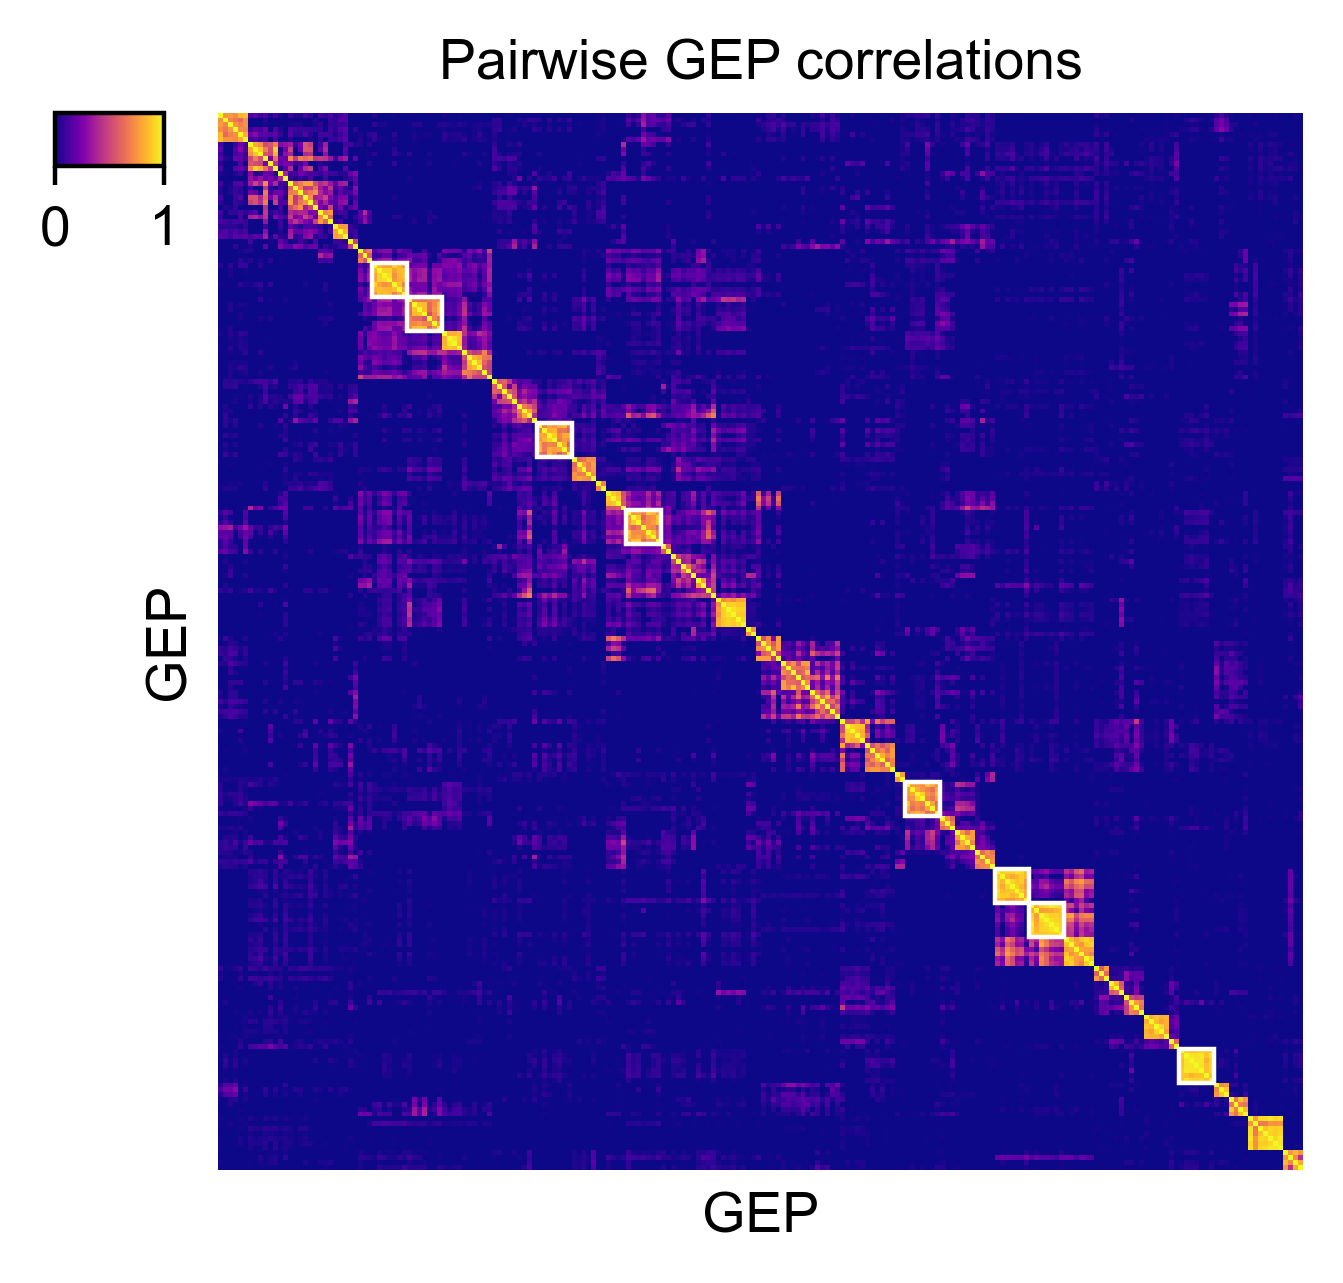

In [82]:
fig, ax = plt.subplots(dpi = 400, figsize = (3.5, 3.5))
sns.heatmap(R_filt.loc[gep_corr_order , gep_corr_order], vmin = 0, vmax = 1, cbar=False,
           yticklabels=False, xticklabels=False, cmap = 'plasma')
ax.set_xlabel('GEP', fontsize = label_fontsize)
ax.set_ylabel('GEP', fontsize = label_fontsize)
ax.set_title('Pairwise GEP correlations', fontsize = label_fontsize)
ax.tick_params(left=False, bottom=False)
cax = ax.inset_axes([-.15, .95, 0.1, 0.05], transform=ax.transAxes)
fig.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), 
                            cmap=sns.color_palette("plasma", as_cmap=True)),
             ax=ax, cax=cax, orientation='horizontal')

for cgep in cgeps_to_plot:
    print(cgep)
    sub_geps = [g for g in gep_corr_order if g in clus_df.loc[cgep,].values]
    ind = gep_corr_order.index(sub_geps[0])    
    ax.add_patch(Rectangle((ind, ind), len(sub_geps), len(sub_geps), fill=False, edgecolor='white', lw=.8))

plt.savefig(os.path.join(figdir, 'AllGep_PairwiseCorr_Heatmap.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'AllGep_PairwiseCorr_Heatmap.pdf'), bbox_inches="tight")

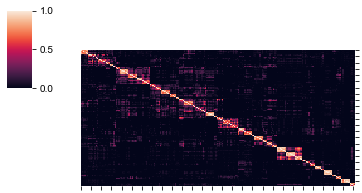

In [83]:
# plotting the clustermap
# fig = plt.figure(dpi = 1000)
g = sns.clustermap(R_filt.loc[gep_corr_order , gep_corr_order], figsize = (7, 6), vmin = 0, vmax = 1, #height=8.27, aspect=11.7/8.27,
           # don't turn off row_clustering, because it will do some default clustering/ordering
           row_cluster=False,
            col_cluster=False,

           # # set the row_linkage to a custom linkage generated from the distance matrix
           # row_linkage=linkage(ssd.squareform(distance_matrix)),
           #  col_linkage=linkage(ssd.squareform(distance_matrix)),

           # row_colors=cmap_all(pd.factorize(clus_list_adj_filt)[0].tolist()),
           #  col_colors = cmap_all(pd.factorize(clus_list_adj_filt)[0].tolist())
          )
g.ax_heatmap.set_xticklabels('')#g.ax_heatmap.get_xmajorticklabels(), fontsize = 31)
g.ax_heatmap.set_yticklabels('')#g.ax_heatmap.get_ymajorticklabels(), fontsize = 31)
# g.legend(prop=dict(size=60))
# plt.title('Z HVG union', {'fontsize': 50})
plt.show()

Zoom in on particular meta-programs (or groups of meta-programs)

### Insets

In [84]:
from matplotlib.pyplot import rc_context

In [85]:
cgep_plot_order

['Cytotoxic',
 'CD8-EM',
 'Treg',
 'Cytoskeleton',
 'MAIT',
 'CellCycle-S',
 'CellCycle-G2M',
 'ISG']

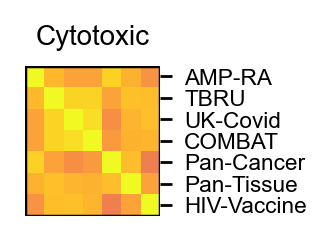

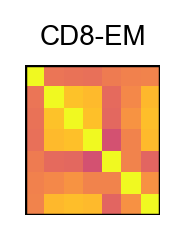

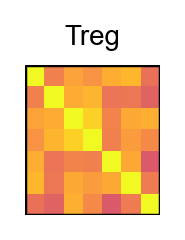

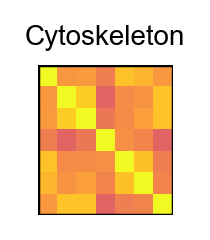

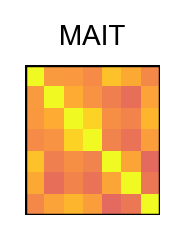

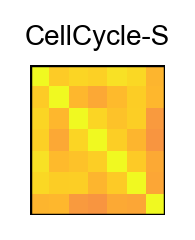

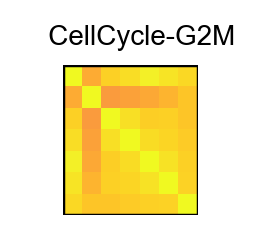

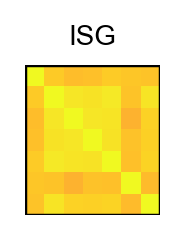

In [132]:
for i,cgep in enumerate(cgep_plot_order):
    sub_geps = [g for g in gep_corr_order if g in clus_df.loc[cgep,].values]

    inset_gep_order = [g for g in gep_corr_order if g in sub_geps]
    inset_ds_order = [g.split(':')[0] for g in inset_gep_order]

    fig, ax = plt.subplots(dpi = 250, figsize = (1.2, 1.2), gridspec_kw={'left':.05, 'right':.5, 'bottom':.25, 'top':.75})    
    
    sns.heatmap(R_filt.loc[inset_gep_order , inset_gep_order], vmin = 0, vmax = 1, cbar=False, yticklabels=True,
                    xticklabels=inset_ds_order, cmap = 'plasma')
    
    if i == 0:
        ax.yaxis.tick_right()
        ax.set_xticks([])
        ax.set_yticklabels([x.split(':')[0] for x in inset_gep_order], rotation = 0, fontsize=6.5)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    if cgep != 'CellCycle-G2M':
        ax.set_title(cgep, fontsize=8)
    else:
        ax.set_title('   ' +  cgep, fontsize=8)
        
        
    ax.add_patch(Rectangle((0, 0), len(sub_geps), len(sub_geps), fill=False, edgecolor='black', lw=1))

    plt.savefig(os.path.join(figdir, '%s_PairwiseCorr_Heatmap.png' % cgep))
    plt.savefig(os.path.join(figdir, '%s_PairwiseCorr_Heatmap.pdf' % cgep))

## Pairwise scatterplot correlations

In [133]:
params

dataset                                           usage_fn  \
dataset                                                                       
AMP-RA            AMP-RA  /data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....   
Pan-Cancer    Pan-Cancer  /data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...   
TBRU                TBRU  /data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...   
HIV-Vaccine  HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...   
UK-Covid        UK-Covid  /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...   
COMBAT            COMBAT  /data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...   
Pan-Tissue    Pan-Tissue  /data/srlab1/TCAT/Data/PerDataset/XTissueImmun...   

                                                gene_scores_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....   
Pan-Cancer   /data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...   
TBRU         /data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...   
HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...   
UK-Covid     /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...   
COMBAT       /data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...   
Pan-Tissue   /data/srlab1/TCAT/Data/PerDataset/XTissueImmun...   

                                                   gene_tpm_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....   
Pan-Cancer   /data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...   
TBRU         /data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...   
HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...   
UK-Covid     /data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...   
COMBAT       /data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...   
Pan-Tissue   /data/srlab1/TCAT/Data/PerDataset/XTissueImmun...   

                                                       tcat_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Cancer   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
TBRU         /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
HIV-Vaccine  /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
UK-Covid     /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
COMBAT       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Tissue   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   

                                        tcat_fn_withsingletons  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Cancer   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
TBRU         /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
HIV-Vaccine  /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
UK-Covid     /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
COMBAT       /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   
Pan-Tissue   /data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...   

                                              manual_gating_fn  \
dataset                                                          
AMP-RA                                                     NaN   
Pan-Cancer                                                 NaN   
TBRU                                                       NaN   
HIV-Vaccine  /data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...   
UK-Covid     /data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...   
COMBAT       /data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...   
Pan-Tissue                                                 NaN   

                                   manual_activation_gating_fn  \
dataset                                                          
AMP-RA       /data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...   
Pan-Cancer                                                 NaN   
TBRU         /data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...   


In [134]:
gene_scores_union = pd.DataFrame()
for dataset in params.index:
    gene_scores = pd.read_csv(params.loc[dataset, 'gene_scores_fn'], sep='\t', index_col=0).T
    gene_scores.index = [dataset + ':'+ str(x) for x in gene_scores.index]
    gene_scores_union = pd.concat([gene_scores_union, gene_scores])


In [135]:
gene_scores_union.shape

(267, 20617)

In [136]:
cgeps_scatter = ['Treg', 'ISG', 'Cytotoxic', 'HLA', 'Cytoskeleton', 'HLA',
                'CD4-Naive', 'CD8-Naive', 'Th2-Activated', 'Th2-Resting', 
                 'Th17-Resting', 'Th17-Activated', 'MAIT', 
                # 'Tfh-1', 
                 'Tfh-2']

In [137]:
clus_df.index

Index(['CellCycle-G2M', 'Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC',
       'gdT', 'CellCycle-S', 'Cytotoxic', 'Doublet-Platelet', 'NME1/FABP5',
       'Th22', 'MAIT', 'CellCycle-Late-S', 'Cytoskeleton', 'Heatshock',
       'Multi-Cytokine', 'TEMRA', 'Doublet-Myeloid', 'Metallothionein',
       'CD4-CM', 'IEG', 'CD8-EM', 'IEG2', 'CD4-Naive', 'Treg', 'Th17-Resting',
       'Poor-Quality', 'CD8-Naive', 'RGCC/MYADM', 'TIMD4/TIM3',
       'Doublet-Plasmablast', 'BCL2/FAM13A', 'IL10/IL19', 'Th2-Activated',
       'Th2-Resting', 'ICOS/CD38', 'Doublet-Bcell', 'Th1-Like', 'CTLA4/CD38',
       'CD8-Trm', 'Th17-Activated', 'Tfh-2', 'OX40/EBI3', 'CD172a/MERTK',
       'IEG3', 'Doublet-Fibroblast', 'SOX4/TOX2', 'CD40LG/TXNIP', 'Tph',
       'Exhaustion', 'Tfh-1'],
      dtype='object')

In [138]:
cgep_scatter_pairs = {}
for cgep in cgeps_scatter:
    print(cgep)
    sub_geps = list(clus_df.loc[cgep, :].dropna().values)
    sub_gep_corrs = R.loc[sub_geps, sub_geps].copy()
    np.fill_diagonal(sub_gep_corrs.values, 0)
    
    display(sub_gep_corrs.unstack().sort_values(ascending = False).head(10))
    cgep_scatter_pairs[cgep] = sorted(list(
        sub_gep_corrs.unstack().sort_values(ascending = False).head(1).index.tolist()[0]))

    print()

Treg


UK-Covid:Treg     COMBAT:Treg         0.902761
COMBAT:Treg       UK-Covid:Treg       0.902761
Pan-Tissue:Treg   AMP-RA:Treg         0.841323
AMP-RA:Treg       Pan-Tissue:Treg     0.841323
COMBAT:Treg       TBRU:Treg           0.833407
TBRU:Treg         COMBAT:Treg         0.833407
UK-Covid:Treg     HIV-Vaccine:Treg    0.821214
HIV-Vaccine:Treg  UK-Covid:Treg       0.821214
Pan-Cancer:Treg   AMP-RA:Treg         0.817559
AMP-RA:Treg       Pan-Cancer:Treg     0.817559
dtype: float64


ISG


Pan-Cancer:ISG   TBRU:ISG           0.963365
TBRU:ISG         Pan-Cancer:ISG     0.963365
                 UK-Covid:ISG       0.956470
UK-Covid:ISG     TBRU:ISG           0.956470
                 COMBAT:ISG         0.956422
COMBAT:ISG       UK-Covid:ISG       0.956422
HIV-Vaccine:ISG  TBRU:ISG           0.952542
TBRU:ISG         HIV-Vaccine:ISG    0.952542
Pan-Cancer:ISG   UK-Covid:ISG       0.952520
UK-Covid:ISG     Pan-Cancer:ISG     0.952520
dtype: float64


Cytotoxic


COMBAT:Cytotoxic       UK-Covid:Cytotoxic       0.939408
UK-Covid:Cytotoxic     COMBAT:Cytotoxic         0.939408
TBRU:Cytotoxic         COMBAT:Cytotoxic         0.912644
COMBAT:Cytotoxic       TBRU:Cytotoxic           0.912644
UK-Covid:Cytotoxic     TBRU:Cytotoxic           0.912369
TBRU:Cytotoxic         UK-Covid:Cytotoxic       0.912369
AMP-RA:Cytotoxic       Pan-Cancer:Cytotoxic     0.904157
Pan-Cancer:Cytotoxic   AMP-RA:Cytotoxic         0.904157
UK-Covid:Cytotoxic     HIV-Vaccine:Cytotoxic    0.867019
HIV-Vaccine:Cytotoxic  UK-Covid:Cytotoxic       0.867019
dtype: float64


HLA


UK-Covid:HLA    COMBAT:HLA        0.945277
COMBAT:HLA      UK-Covid:HLA      0.945277
Pan-Cancer:HLA  UK-Covid:HLA      0.915115
UK-Covid:HLA    Pan-Cancer:HLA    0.915115
Pan-Tissue:HLA  Pan-Cancer:HLA    0.910261
Pan-Cancer:HLA  Pan-Tissue:HLA    0.910261
UK-Covid:HLA    Pan-Tissue:HLA    0.909275
Pan-Tissue:HLA  UK-Covid:HLA      0.909275
TBRU:HLA        COMBAT:HLA        0.903726
COMBAT:HLA      TBRU:HLA          0.903726
dtype: float64


Cytoskeleton


TBRU:Cytoskeleton         UK-Covid:Cytoskeleton       0.891901
UK-Covid:Cytoskeleton     TBRU:Cytoskeleton           0.891901
                          HIV-Vaccine:Cytoskeleton    0.874744
HIV-Vaccine:Cytoskeleton  UK-Covid:Cytoskeleton       0.874744
                          TBRU:Cytoskeleton           0.874554
TBRU:Cytoskeleton         HIV-Vaccine:Cytoskeleton    0.874554
Pan-Cancer:Cytoskeleton   AMP-RA:Cytoskeleton         0.867810
AMP-RA:Cytoskeleton       Pan-Cancer:Cytoskeleton     0.867810
Pan-Tissue:Cytoskeleton   Pan-Cancer:Cytoskeleton     0.866452
Pan-Cancer:Cytoskeleton   Pan-Tissue:Cytoskeleton     0.866452
dtype: float64


HLA


UK-Covid:HLA    COMBAT:HLA        0.945277
COMBAT:HLA      UK-Covid:HLA      0.945277
Pan-Cancer:HLA  UK-Covid:HLA      0.915115
UK-Covid:HLA    Pan-Cancer:HLA    0.915115
Pan-Tissue:HLA  Pan-Cancer:HLA    0.910261
Pan-Cancer:HLA  Pan-Tissue:HLA    0.910261
UK-Covid:HLA    Pan-Tissue:HLA    0.909275
Pan-Tissue:HLA  UK-Covid:HLA      0.909275
TBRU:HLA        COMBAT:HLA        0.903726
COMBAT:HLA      TBRU:HLA          0.903726
dtype: float64


CD4-Naive


AMP-RA:CD4-Naive          Pan-Tissue:CD4-Naive        0.782211
Pan-Tissue:CD4-Naive      AMP-RA:CD4-Naive            0.782211
Pan-Cancer:CD4-Naive      AMP-RA:CD4-Naive            0.775147
AMP-RA:CD4-Naive          Pan-Cancer:CD4-Naive        0.775147
UK-Covid:CD4-Naive        HIV-Vaccine:CD4-Naive       0.740228
HIV-Vaccine:CD4-Naive     UK-Covid:CD4-Naive          0.740228
Pan-Tissue:CD4-Naive      Pan-Cancer:CD4-Naive        0.733101
Pan-Cancer:CD4-Naive      Pan-Tissue:CD4-Naive        0.733101
UK-Covid:CD4-Naive        TBRU:TBRU:T_Naive_Single    0.700822
TBRU:TBRU:T_Naive_Single  UK-Covid:CD4-Naive          0.700822
dtype: float64


CD8-Naive


UK-Covid:CD8-Naive     HIV-Vaccine:CD8-Naive    0.768631
HIV-Vaccine:CD8-Naive  UK-Covid:CD8-Naive       0.768631
UK-Covid:CD8-Naive     Pan-Tissue:CD8-Naive     0.713554
Pan-Tissue:CD8-Naive   UK-Covid:CD8-Naive       0.713554
                       HIV-Vaccine:CD8-Naive    0.603858
HIV-Vaccine:CD8-Naive  Pan-Tissue:CD8-Naive     0.603858
UK-Covid:CD8-Naive     UK-Covid:CD8-Naive       0.000000
Pan-Tissue:CD8-Naive   Pan-Tissue:CD8-Naive     0.000000
HIV-Vaccine:CD8-Naive  HIV-Vaccine:CD8-Naive    0.000000
dtype: float64


Th2-Activated


TBRU:CCR3+-Th2      UK-Covid:CCR3+-Th2    0.768752
UK-Covid:CCR3+-Th2  TBRU:CCR3+-Th2        0.768752
TBRU:CCR3+-Th2      TBRU:CCR3+-Th2        0.000000
UK-Covid:CCR3+-Th2  UK-Covid:CCR3+-Th2    0.000000
dtype: float64


Th2-Resting


COMBAT:Th2       HIV-Vaccine:Th2    0.736269
HIV-Vaccine:Th2  COMBAT:Th2         0.736269
TBRU:Th2         COMBAT:Th2         0.730771
COMBAT:Th2       TBRU:Th2           0.730771
UK-Covid:Th2     HIV-Vaccine:Th2    0.707343
HIV-Vaccine:Th2  UK-Covid:Th2       0.707343
UK-Covid:Th2     COMBAT:Th2         0.690164
COMBAT:Th2       UK-Covid:Th2       0.690164
TBRU:Th2         HIV-Vaccine:Th2    0.649750
HIV-Vaccine:Th2  TBRU:Th2           0.649750
dtype: float64


Th17-Resting


UK-Covid:Th17     COMBAT:Th17         0.828173
COMBAT:Th17       UK-Covid:Th17       0.828173
UK-Covid:Th17     HIV-Vaccine:Th17    0.777800
HIV-Vaccine:Th17  UK-Covid:Th17       0.777800
TBRU:Th17         HIV-Vaccine:Th17    0.770949
HIV-Vaccine:Th17  TBRU:Th17           0.770949
TBRU:Th17         UK-Covid:Th17       0.760296
UK-Covid:Th17     TBRU:Th17           0.760296
COMBAT:Th17       HIV-Vaccine:Th17    0.700345
HIV-Vaccine:Th17  COMBAT:Th17         0.700345
dtype: float64


Th17-Activated


TBRU:IL26/CTSH    COMBAT:IL26/CTSH    0.746087
COMBAT:IL26/CTSH  TBRU:IL26/CTSH      0.746087
TBRU:IL26/CTSH    TBRU:IL26/CTSH      0.000000
COMBAT:IL26/CTSH  COMBAT:IL26/CTSH    0.000000
dtype: float64


MAIT


COMBAT:MAIT       UK-Covid:MAIT       0.906820
UK-Covid:MAIT     COMBAT:MAIT         0.906820
Pan-Cancer:MAIT   AMP-RA:MAIT         0.867581
AMP-RA:MAIT       Pan-Cancer:MAIT     0.867581
HIV-Vaccine:MAIT  UK-Covid:MAIT       0.837757
UK-Covid:MAIT     HIV-Vaccine:MAIT    0.837757
                  TBRU:MAIT           0.810719
TBRU:MAIT         UK-Covid:MAIT       0.810719
AMP-RA:MAIT       Pan-Tissue:MAIT     0.805944
Pan-Tissue:MAIT   AMP-RA:MAIT         0.805944
dtype: float64


Tfh-2


AMP-RA:AMP-RA:SERPINE2_Single      Pan-Tissue:Tfh                       0.596782
Pan-Tissue:Tfh                     AMP-RA:AMP-RA:SERPINE2_Single        0.596782
AMP-RA:AMP-RA:SERPINE2_Single      Pan-Cancer:AMP-RA:SERPINE2_Single    0.559116
Pan-Cancer:AMP-RA:SERPINE2_Single  AMP-RA:AMP-RA:SERPINE2_Single        0.559116
                                   Pan-Tissue:Tfh                       0.557120
Pan-Tissue:Tfh                     Pan-Cancer:AMP-RA:SERPINE2_Single    0.557120
AMP-RA:AMP-RA:SERPINE2_Single      AMP-RA:AMP-RA:SERPINE2_Single        0.000000
Pan-Cancer:AMP-RA:SERPINE2_Single  Pan-Cancer:AMP-RA:SERPINE2_Single    0.000000
Pan-Tissue:Tfh                     Pan-Tissue:Tfh                       0.000000
dtype: float64

In [139]:
# Tissue datasets had more ribosomal genes
cgep_scatter_pairs['CD4-Naive'] = sorted(['UK-Covid:CD4-Naive','HIV-Vaccine:CD4-Naive'])

# Include some tissue datasets as well
cgep_scatter_pairs['Cytotoxic'] = sorted(['AMP-RA:Cytotoxic', 'Pan-Cancer:Cytotoxic'])

In [140]:
genes_to_label = {}
genes_to_label.update({'': []})

genes_to_label.update({'Th2-Activated': ['GATA3','CCR4',  'CCR8'],
                      'Th2-Resting' : ['GATA3', 'CCR4', 'CCR8'],
                      'Th17-Resting': ['RORC', 'CCR4', 'CCR6'],
                      'Th17-Activated': ['RORC', 'CCR4', 'CCR6']})

genes_to_label.update({'Cytotoxic' : ['GZMB']})

In [141]:
cgeps_scatter_filt = ['Treg',
 'ISG',
 'MAIT',
 'Cytotoxic',
 'Cytoskeleton',
 'Th2-Resting']

Treg
0.8790822779134404 0.0
['IL2RA', 'FOXP3', 'AB_CD25', 'AB_CD39', 'FANK1', 'RTKN2', 'CTLA4', 'AB_CD95']
ISG
0.9458137602178744 0.0
['IFIT1', 'IFIT3', 'ISG15', 'IFI6', 'MX1', 'RSAD2']
MAIT
0.8687010608360313 0.0
['TRAV1-2', 'AB_TCR-V-7.2', 'AB_CD161', 'SLC4A10', 'KLRB1', 'IL23R']
Cytotoxic
0.8492173034532936 0.0
['S1PR5', 'PRSS23', 'FGFBP2', 'CX3CR1', 'GZMB', 'GZMH', 'PRF1', 'NKG7']
Cytoskeleton
0.8890681699837228 0.0
['CORO1A', 'PFN1', 'CFL1', 'ACTG1', 'ACTB']
Th2-Resting
0.6783330645074201 0.0
['SEMA5A', 'KRT1', 'NEFL', 'CCR8', 'PTGDR2', 'CDO1', 'ZP1', 'CCR4', 'GATA3']


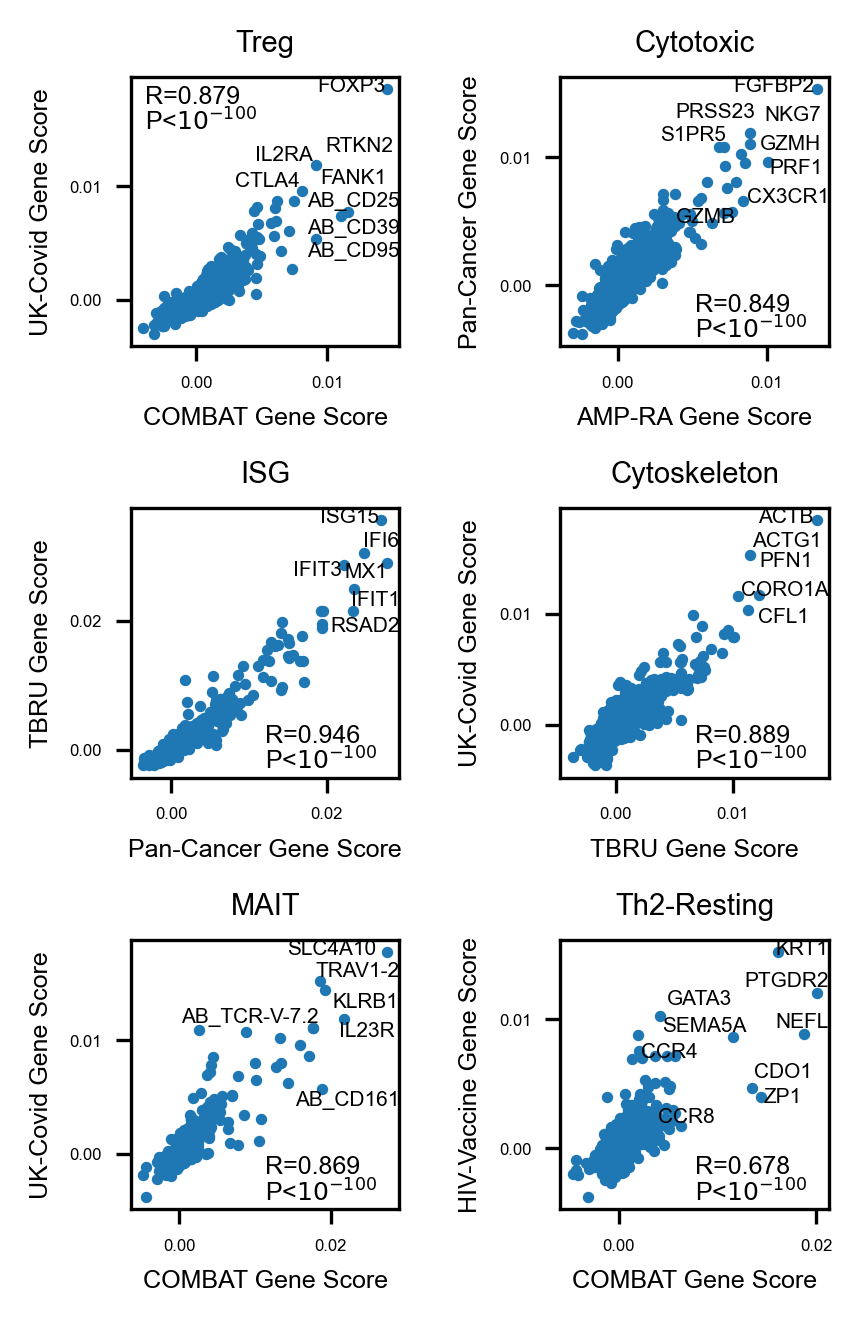

In [172]:
figsize = (3, 5)
label_genes = True
ngenes_label = 5
labels = None
label_size = 5

nrow = 3
ncol = 2
wspace = 0.6
hspace = 0.6

with rc_context({'figure.figsize': figsize, 'figure.dpi':300,
                'xtick.labelsize': label_size-1,
                 'ytick.labelsize': label_size-1}):
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, gridspec_kw ={'wspace': wspace, 'hspace': hspace})

    for n, cgep in  enumerate(cgeps_scatter_filt):
        # labels=None
        if cgep in genes_to_label.keys():
            labels = genes_to_label[cgep]
        else:
            labels = None
        print(cgep)
        i = (n)%nrow
        j = (n)//nrow

        gene_scores_pair = gene_scores_union.loc[cgep_scatter_pairs[cgep], :].dropna(axis = 1)
        ds_pair= [g.split(':')[0] for g in gene_scores_pair.index]
        r, p = pearsonr(gene_scores_pair.iloc[0, :], gene_scores_pair.iloc[1, :])
        print(r,p)
        
        ax[i, j].set_xlabel('%s Gene Score' % ds_pair[0], fontsize = tick_fontsize-2)
        ax[i, j].set_ylabel('%s Gene Score' % ds_pair[1], fontsize = tick_fontsize-2)
        
        
        if cgep != 'Treg':
            xloc = .5
            yloc = .13
        else:
            xloc = .05
            yloc = .9
        
        ax[i, j].text(x = xloc, y = yloc, s = ''.join(['R=', str(round(r, 3))]), transform=ax[i, j].transAxes,
                     fontsize = 6)
        if p==0:
            ax[i, j].text(x = xloc, y = yloc-.1, s = 'P<$10^{-100}$' % p, transform=ax[i, j].transAxes,
                         fontsize = 6)
        else:
            ax[i, j].text(x = xloc, y = yloc-.1, s = 'P=%.2E' % p, transform=ax[i, j].transAxes,
                         fontsize = 6)
        ax[i, j].scatter(x = gene_scores_pair.iloc[0, :], y = gene_scores_pair.iloc[1, :], s = 3, rasterized=True)
        ax[i, j].set_title(cgep, fontsize = tick_fontsize-1#label_fontsize
                          )
        

        
        #xlim = ax[i, j].get_xlim()
        #ylim = ax[i, j].get_ylim()
        #ax[i,j].set_xlim([xlim[0], xlim[1]*1.1])
        #ax[i,j].set_ylim([ylim[0], ylim[1]*1.1])  
        
        # Plot top genes 
        if label_genes == True:
            texts = []

            labels_top = list(set(gene_scores_pair.T.sort_values(by = gene_scores_pair.index[0], 
                ascending = False).index[0:ngenes_label].tolist() +
                 gene_scores_pair.T.sort_values(by = gene_scores_pair.index[1], 
                ascending = False).index[0:ngenes_label].tolist()))
            
            if labels!=None:
                labels = list(set(labels + labels_top))
            else: 
                labels = labels_top

            print(labels)

  
            
            texts = []
            for x, y, s in zip(gene_scores_pair.iloc[0, :][labels], 
                               gene_scores_pair.iloc[1, :][labels], 
                               labels):
                texts.append(ax[i, j].text(x, y, s, fontsize = label_size))
            #adjust_text(texts, ax = ax[i, j], arrowprops=dict(arrowstyle='-', color='grey', 
            #                                                  linewidth = .3))

            adjust_text(texts, ax = ax[i, j])
            

        
            
plt.savefig(os.path.join(figdir, 'SpectraCorrelation_Scatterplots.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'SpectraCorrelation_Scatterplots.pdf'), bbox_inches="tight")


Treg
['FANK1', 'AB_CD95', 'CTLA4', 'FOXP3', 'AB_CD39', 'IL2RA', 'AB_CD25', 'RTKN2']
ISG
['ISG15', 'RSAD2', 'IFIT3', 'MX1', 'IFI6', 'IFIT1']
MAIT
['SLC4A10', 'KLRB1', 'AB_TCR-V-7.2', 'IL23R', 'TRAV1-2', 'AB_CD161']
Cytotoxic
['NKG7', 'PRSS23', 'GZMB', 'PRF1', 'GZMH', 'FGFBP2', 'S1PR5', 'CX3CR1']
Cytoskeleton
['ACTB', 'CORO1A', 'ACTG1', 'PFN1', 'CFL1']
Th2-Resting
['GATA3', 'CCR4', 'PTGDR2', 'ZP1', 'NEFL', 'CDO1', 'SEMA5A', 'KRT1', 'CCR8']


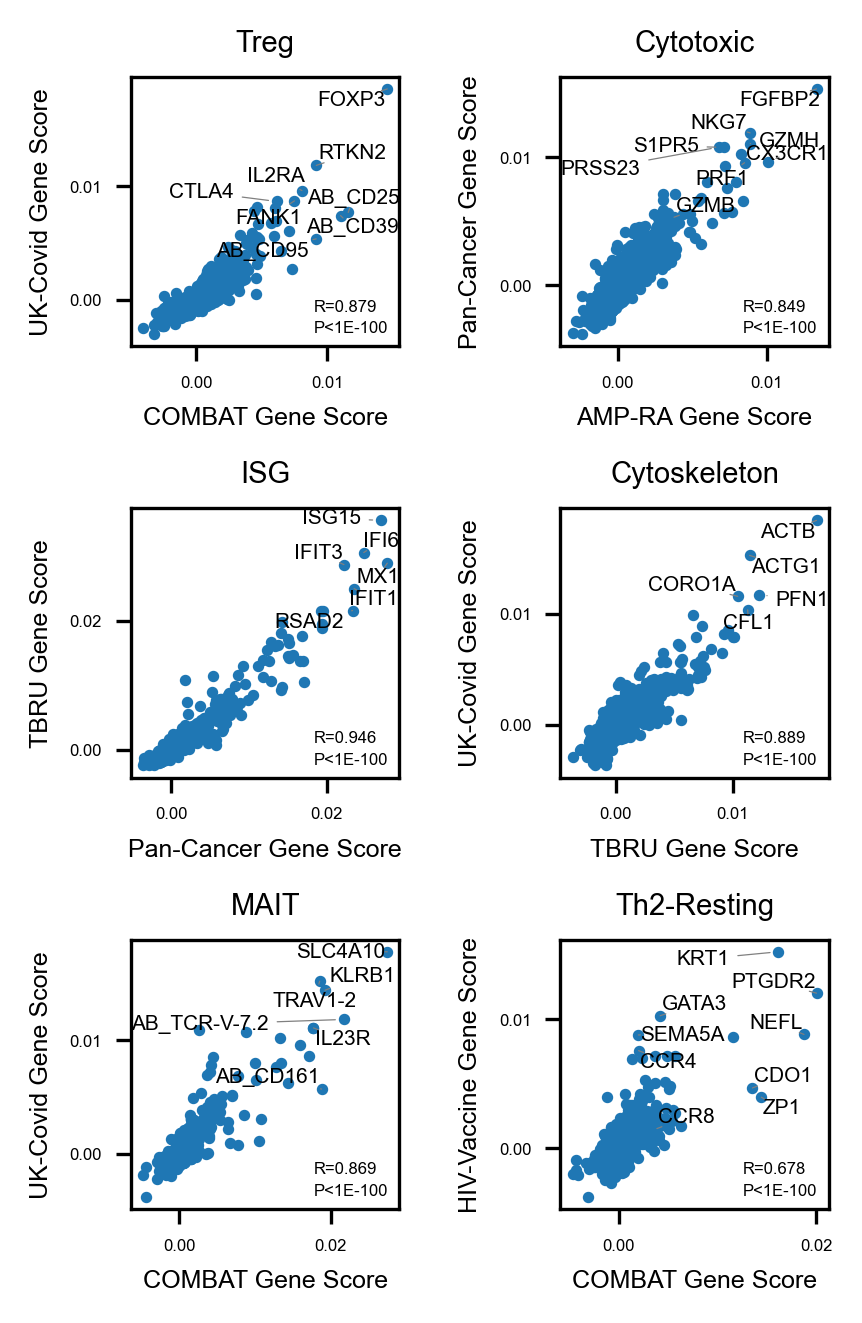

In [321]:
figsize = (3, 5)
label_genes = True
ngenes_label = 5
labels = None
label_size = 5

nrow = 3
ncol = 2
wspace = 0.6
hspace = 0.6

with rc_context({'figure.figsize': figsize, 'figure.dpi':300,
                'xtick.labelsize': label_size-1,
                 'ytick.labelsize': label_size-1}):
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, gridspec_kw ={'wspace': wspace, 'hspace': hspace})

    for n, cgep in  enumerate(cgeps_scatter_filt):
        # labels=None
        if cgep in genes_to_label.keys():
            labels = genes_to_label[cgep]
        else:
            labels = None
        print(cgep)
        i = (n)%nrow
        j = (n)//nrow

        gene_scores_pair = gene_scores_union.loc[cgep_scatter_pairs[cgep], :].dropna(axis = 1)
        ds_pair= [g.split(':')[0] for g in gene_scores_pair.index]
        r, p = pearsonr(gene_scores_pair.iloc[0, :], gene_scores_pair.iloc[1, :])
        
        ax[i, j].set_xlabel('%s Gene Score' % ds_pair[0], fontsize = tick_fontsize-2)
        ax[i, j].set_ylabel('%s Gene Score' % ds_pair[1], fontsize = tick_fontsize-2)
        ax[i, j].text(x = .68, y = .13, s = ''.join(['R=', str(round(r, 3))]), transform=ax[i, j].transAxes,
                     fontsize = label_size-1)
        if p==0:
            ax[i, j].text(x = .68, y = .05, s = 'P<1E-100' % p, transform=ax[i, j].transAxes,
                         fontsize = label_size-1)
        else:
            ax[i, j].text(x = .68, y = .05, s = 'P=%.2E' % p, transform=ax[i, j].transAxes,
                         fontsize = label_size-1)
        ax[i, j].scatter(x = gene_scores_pair.iloc[0, :], y = gene_scores_pair.iloc[1, :], s = 3)
        ax[i, j].set_title(cgep, fontsize = tick_fontsize-1#label_fontsize
                          )

        # Plot top genes 
        if label_genes == True:
            texts = []

            labels_top = list(set(gene_scores_pair.T.sort_values(by = gene_scores_pair.index[0], 
                ascending = False).index[0:ngenes_label].tolist() +
                 gene_scores_pair.T.sort_values(by = gene_scores_pair.index[1], 
                ascending = False).index[0:ngenes_label].tolist()))
            
            if labels!=None:
                labels = list(set(labels + labels_top))
            else: 
                labels = labels_top

            print(labels)


            texts = []
            for x, y, s in zip(gene_scores_pair.iloc[0, :][labels], 
                               gene_scores_pair.iloc[1, :][labels], 
                               labels):
                texts.append(ax[i, j].text(x, y, s, size = label_size))
            adjust_text(texts, ax = ax[i, j], arrowprops=dict(arrowstyle='-', color='grey', 
                                                              linewidth = .3))

plt.savefig(os.path.join(figdir, 'SpectraCorrelation_Scatterplots.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'SpectraCorrelation_Scatterplots.pdf'), bbox_inches="tight")
plt.show()